<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
# A:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
1         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
2         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
3         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   
4         Lvl    AllPub    ...            0    NaN   NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  

[5 rows x 81 columns]

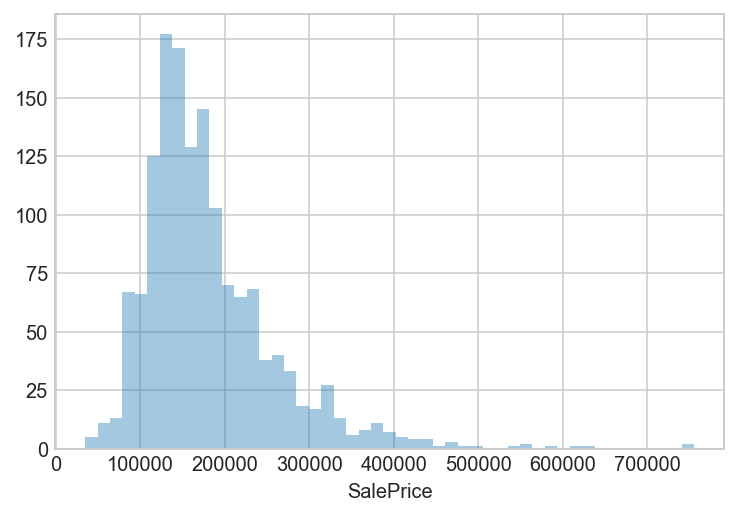

In [4]:
sns.distplot(house.SalePrice,kde=False)

<div class = 'alert alert-block alert-info'> $$Data Munging$$ </div>  

In [5]:
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

<div class = 'alert alert-block alert-warning'> **Create new dataframe of just residential property** </div>  

In [4]:
res = house[~house.MSZoning.isin(['C (all)'])]
res.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

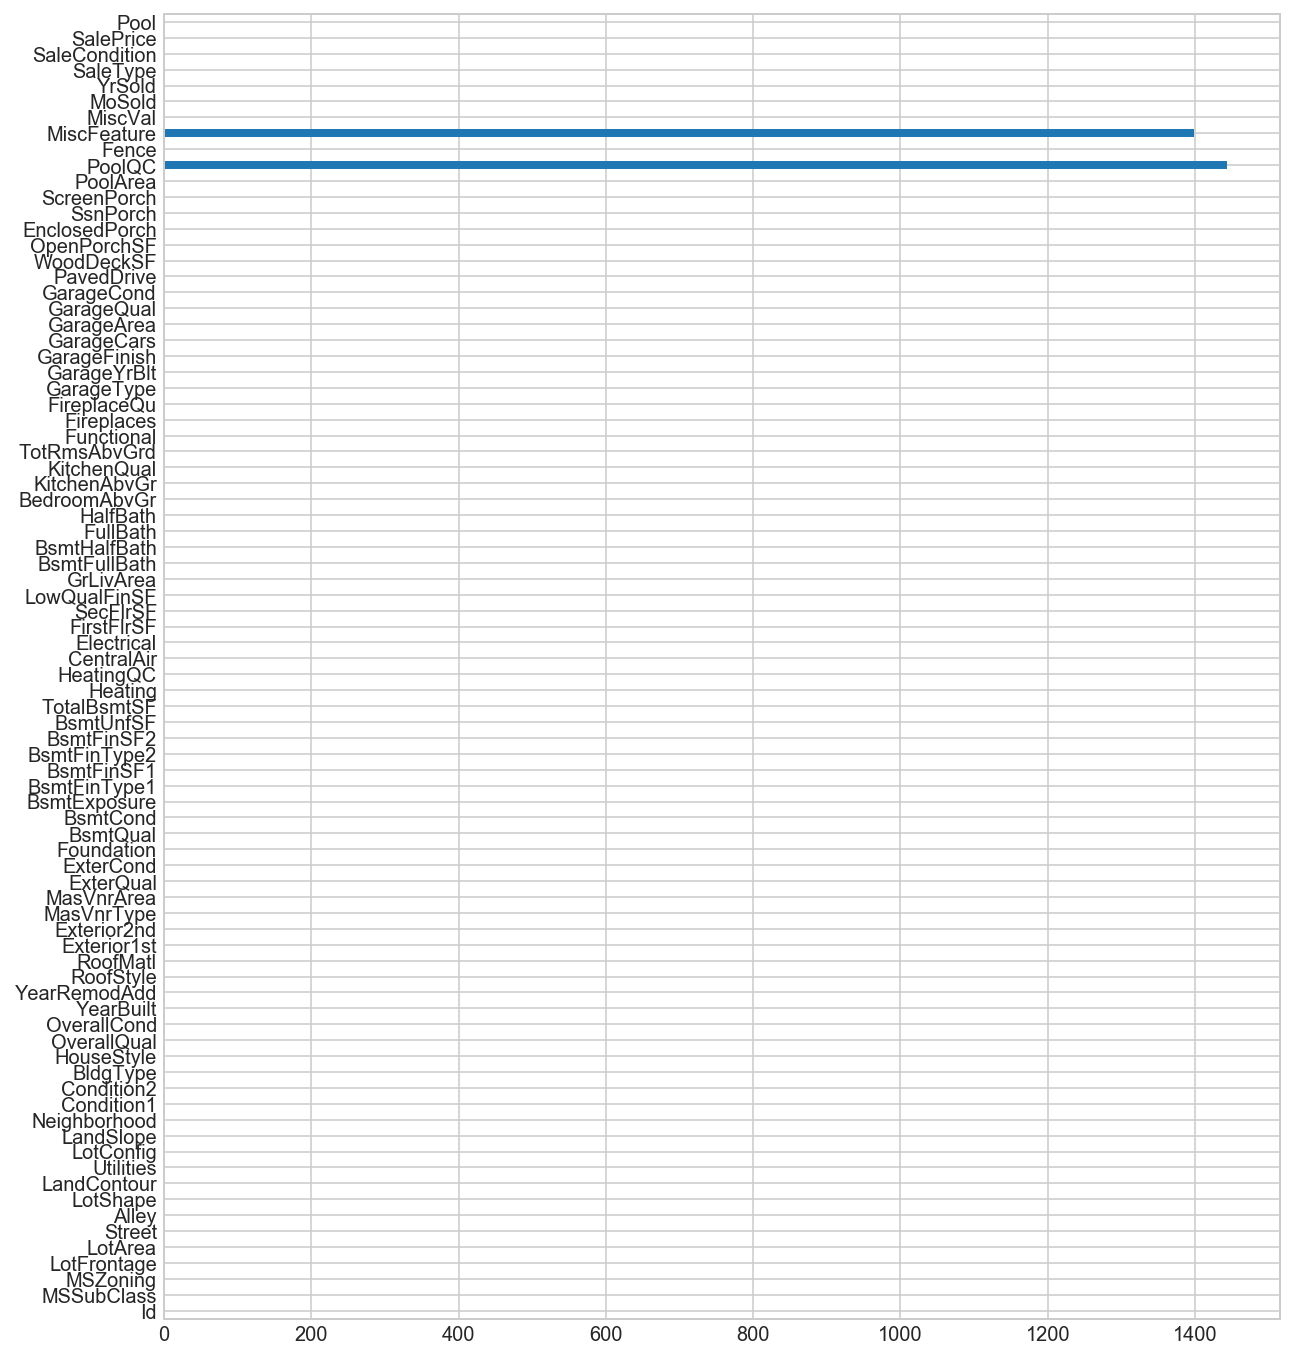

In [65]:
plt.subplots(figsize= (10,12))
res.isnull().sum().plot.barh()

In [66]:
for fea in ['Alley','PoolArea','PoolQC','Fence','MiscFeature']:
    print fea
    print house[fea].value_counts()

Alley
Grvl    50
Pave    41
Name: Alley, dtype: int64
PoolArea
0      1453
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64
PoolQC
Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64
Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64
MiscFeature
Shed    49
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64


<div class = 'alert alert-block alert-info'> Although 'Alley', 'PoolArea', 'PoolQC' and 'Fence' have very few values, instead of dropping these features, let's convert them to binary classes </div>

In [5]:
res['Pool'] = np.where(res['PoolArea'] > 0, 1,  0)
res['Alley'] = res['Alley'].map(lambda x : 0 if str(x) == 'nan' else 1).astype(int)
res['Fence'] = res['Fence'].map(lambda x : 0 if str(x) == 'nan' else 1).astype(int)

/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [6]:
colwmiss = []
missingval = []
for col in res.columns.tolist():
    if res[col].isnull().sum() > 0:
        colwmiss.append(col)
        missingval.append(res[col].isnull().sum())

zip(colwmiss,missingval)

[('LotFrontage', 259),
 ('MasVnrType', 8),
 ('MasVnrArea', 8),
 ('BsmtQual', 37),
 ('BsmtCond', 37),
 ('BsmtExposure', 38),
 ('BsmtFinType1', 37),
 ('BsmtFinType2', 38),
 ('Electrical', 1),
 ('FireplaceQu', 681),
 ('GarageType', 79),
 ('GarageYrBlt', 79),
 ('GarageFinish', 79),
 ('GarageQual', 79),
 ('GarageCond', 79),
 ('PoolQC', 1443),
 ('MiscFeature', 1398)]

<div class = 'alert alert-block alert-info'> Fill in NaNs </div>

In [7]:
for gar in ['GarageType','GarageFinish','GarageQual','GarageCond']:
    res[gar].fillna('No Gar',inplace=True)
    
for base in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']:
    res[base].fillna('No Basemt',inplace = True)
    
res.GarageYrBlt.fillna(res.GarageYrBlt.mean(),inplace=True)

res.FireplaceQu.fillna('No Firepl', inplace=True)

res.LotFrontage.fillna(0., inplace=True)

res.MasVnrArea.fillna(res.MasVnrArea.min(), inplace=True)

res.MasVnrType.fillna('None', inplace=True)

res.Electrical.fillna('SBrkr', inplace=True)

/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [67]:
res.shape

(1450, 82)

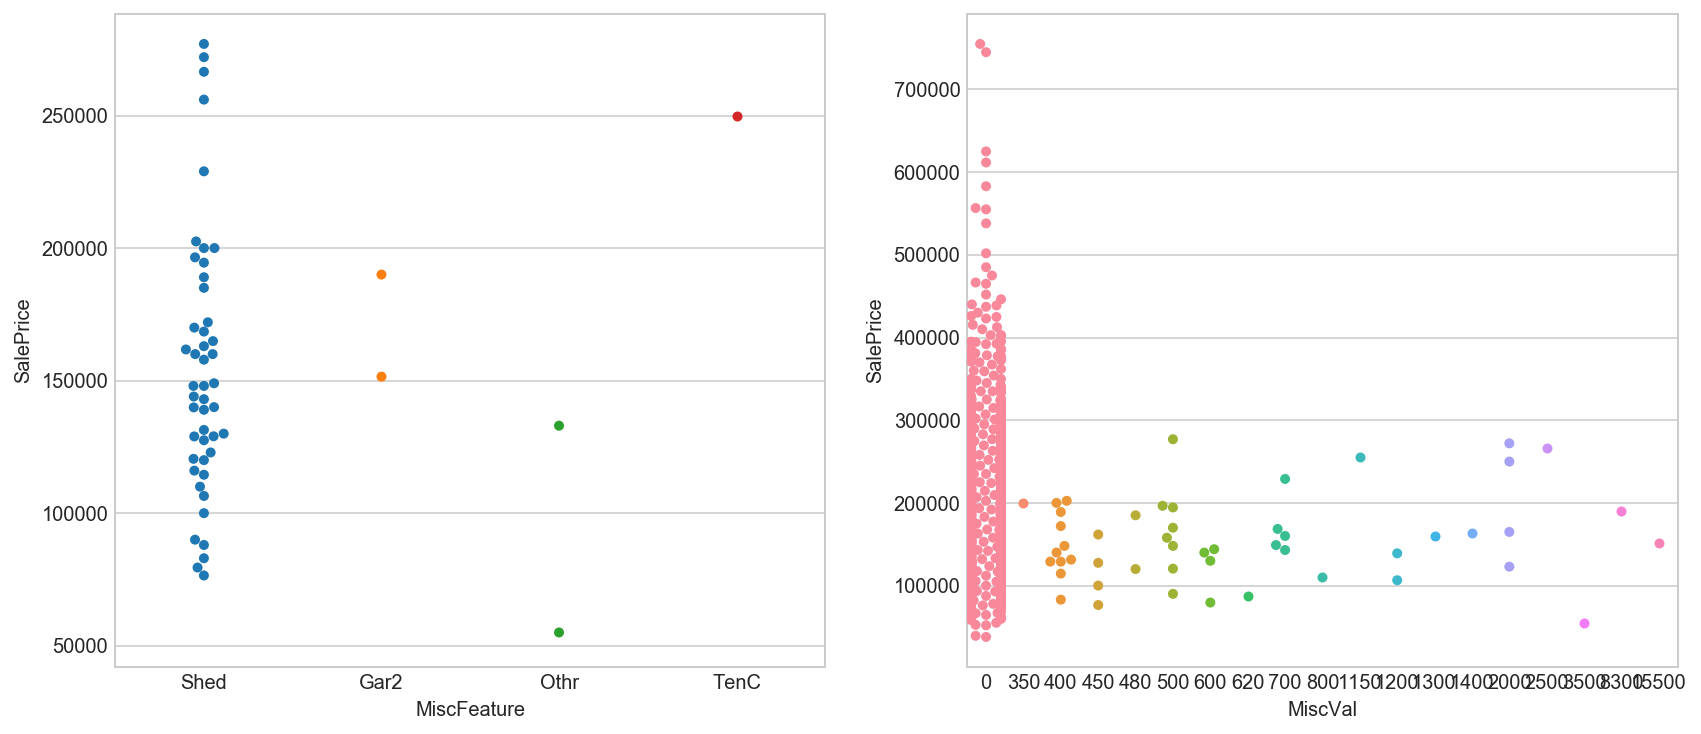

In [68]:
f,ax = plt.subplots(1,2,figsize = (14,6))
sns.swarmplot(x= res.MiscFeature, y=res.SalePrice, data=res, ax=ax[0])
sns.swarmplot(x= res.MiscVal, y=res.SalePrice, data=res, ax=ax[1])

In [69]:
res[res.MiscFeature == 'TenC']['MiscVal']

1386    2000
Name: MiscVal, dtype: int64

In [70]:
print res.SalePrice.corr(res.MiscVal)
print res.SalePrice.corr(res.MiscVal, method = 'spearman')

-0.021052264971
-0.0539357543179


In [9]:
todrop = ['PoolQC', 'PoolArea', 'MiscVal','MiscFeature']
renovatable = ['Utilities','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','ExterQual','ExterCond',
               'BsmtCond','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual',
               'FireplaceQu','GarageFinish','GarageQual','GarageCond']
len(renovatable)

19

<div class = 'alert alert-block alert-warning'>**Create new dataframe of fixed features**</div> 

In [10]:
fixedfeature = res.drop(renovatable+todrop, axis = 1)
fixedfeature.shape

(1450, 59)

<div class = 'alert alert-block alert-info'> $$EDA$$</div>

In [71]:
classcol = []
for col in [c for c in fixedfeature.columns]:
    if fixedfeature[col].dtypes == 'O':
        classcol.append(col)

In [72]:
for cols in classcol:
    print 'Col name : ', cols, 'categories: \n', fixedfeature[cols].nunique(),'\t',fixedfeature[cols].unique()

Col name :  MSZoning categories: 
4 	['RL' 'RM' 'FV' 'RH']
Col name :  Street categories: 
2 	['Pave' 'Grvl']
Col name :  LotShape categories: 
4 	['Reg' 'IR1' 'IR2' 'IR3']
Col name :  LandContour categories: 
4 	['Lvl' 'Bnk' 'Low' 'HLS']
Col name :  LotConfig categories: 
5 	['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Col name :  LandSlope categories: 
3 	['Gtl' 'Mod' 'Sev']
Col name :  Neighborhood categories: 
25 	['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Col name :  Condition1 categories: 
9 	['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Col name :  Condition2 categories: 
8 	['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
Col name :  BldgType categories: 
5 	['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
Col name :  HouseStyle categories: 
8 	['2Story

In [13]:
numeric = fixedfeature.drop(classcol,axis = 1)
categorical = fixedfeature[classcol + ['SalePrice']]
print numeric.shape
print categorical.shape

(1450, 39)
(1450, 21)


In [73]:
numeric.describe()

Id   MSSubClass  LotFrontage        LotArea        Alley  \
count  1450.000000  1450.000000   1450.00000    1450.000000  1450.000000   
mean    731.364138    56.903448     57.54000   10523.831724     0.061379   
std     421.554345    42.265033     34.71992   10012.185355     0.240108   
min       1.000000    20.000000      0.00000    1300.000000     0.000000   
25%     366.250000    20.000000     41.25000    7544.500000     0.000000   
50%     731.500000    50.000000     63.00000    9496.000000     0.000000   
75%    1096.750000    70.000000     79.00000   11613.500000     0.000000   
max    1460.000000   190.000000    313.00000  215245.000000     1.000000   

       OverallQual  OverallCond    YearBuilt  YearRemodAdd   MasVnrArea  \
count  1450.000000  1450.000000  1450.000000   1450.000000  1450.000000   
mean      6.114483     5.582069  1971.593103   1985.049655   103.828276   
std       1.372860     1.107330    30.022696     20.552319   181.150114   
min       1.000000     1.000000  1872.000000   1950.000000     0.000000   
25%       5.000000     5.000000  1954.000000   1967.000000     0.000000   
50%       6.000000     5.000000  1973.000000   1994.000000     0.000000   
75%       7.000000     6.000000  2001.000000   2004.000000   166.000000   
max      10.000000     9.000000  2010.000000   2010.000000  1600.000000   

          ...        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count     ...       1450.000000  1450.000000    1450.000000  1450.000000   
mean      ...         94.826897    46.537931      21.536552     3.433103   
std       ...        125.560863    65.222761      60.838826    29.416948   
min       ...          0.000000     0.000000       0.000000     0.000000   
25%       ...          0.000000     0.000000       0.000000     0.000000   
50%       ...          0.000000    25.000000       0.000000     0.000000   
75%       ...        168.000000    68.000000       0.000000     0.000000   
max       ...        857.000000   547.000000     552.000000   508.000000   

       ScreenPorch        Fence       MoSold       YrSold      SalePrice  \
count  1450.000000  1450.000000  1450.000000  1450.000000    1450.000000   
mean     15.096552     0.191724     6.312414  2007.812414  181654.942069   
std      55.893399     0.393793     2.698244     1.326321   79176.485241   
min       0.000000     0.000000     1.000000  2006.000000   37900.000000   
25%       0.000000     0.000000     5.000000  2007.000000  130000.000000   
50%       0.000000     0.000000     6.000000  2008.000000  163945.000000   
75%       0.000000     0.000000     8.000000  2009.000000  214000.000000   
max     480.000000     1.000000    12.000000  2010.000000  755000.000000   

              Pool  
count  1450.000000  
mean      0.004828  
std       0.069337  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.000000  
max       1.000000  

[8 rows x 39 columns]

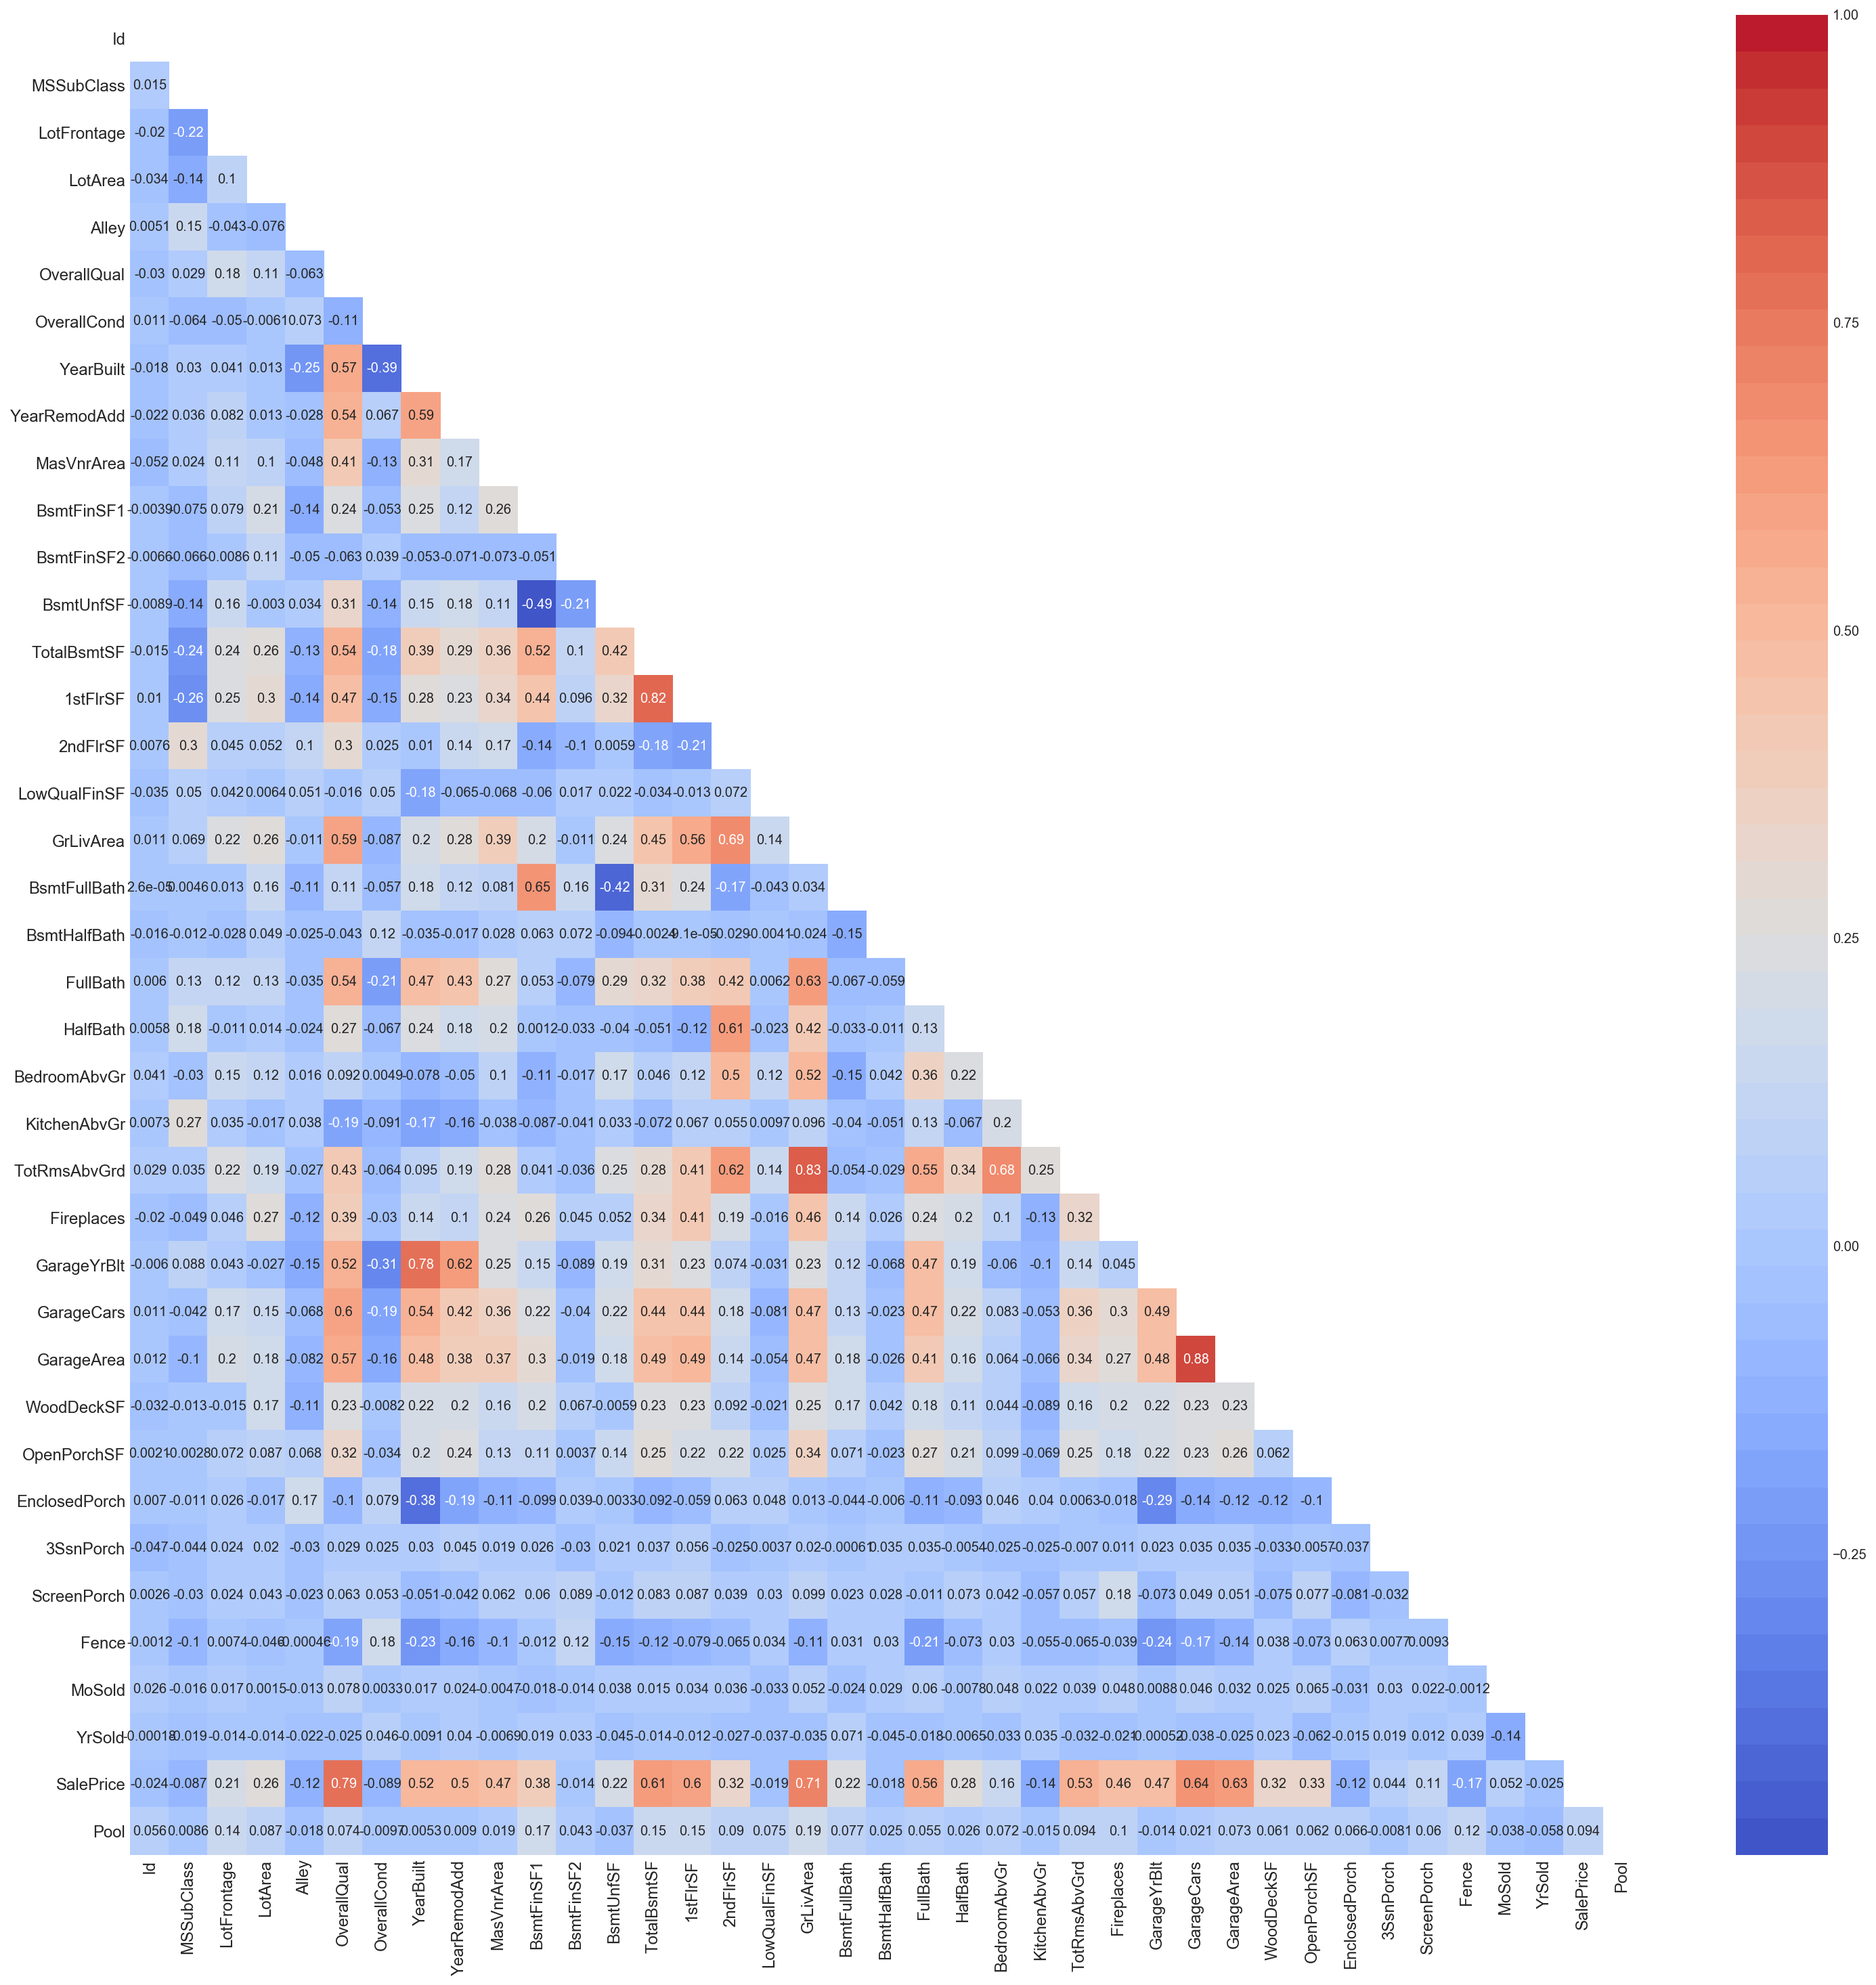

In [23]:
corr =numeric.corr()
f,ax = plt.subplots(figsize = (25,25))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.color_palette('coolwarm',50)
ax =sns.heatmap(corr,mask = mask, annot=True,cmap= cmap)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)
plt.show()

<div class = 'alert alert-block alert-info'> Manually found correlated features:
<br>'GarageArea' <-> 'GarageCars',
<br>'YearBuilt' <-> 'GarageYrBlt',
<br>'1stFlrSF' <-> 'TotalBsmtSF'
<br>'GrLivArea' <->'2ndFlrSF','FullBath','TotRmsAbvGrd'
<br> Hence we discard the features 'GarageCars', 'GarageYrBlt','2ndFlrSF','TotalBsmtSF' since they have lower predictive values </div>

In [14]:
todrop2 = ['Id','GarageCars', 'GarageYrBlt','2ndFlrSF','TotalBsmtSF']

fixedfeature.drop(todrop2,axis=1,inplace=True)

In [74]:
numeric_1 = fixedfeature.drop(classcol,axis = 1)
print numeric_1.shape
print categorical.shape

(1450, 34)
(1450, 21)


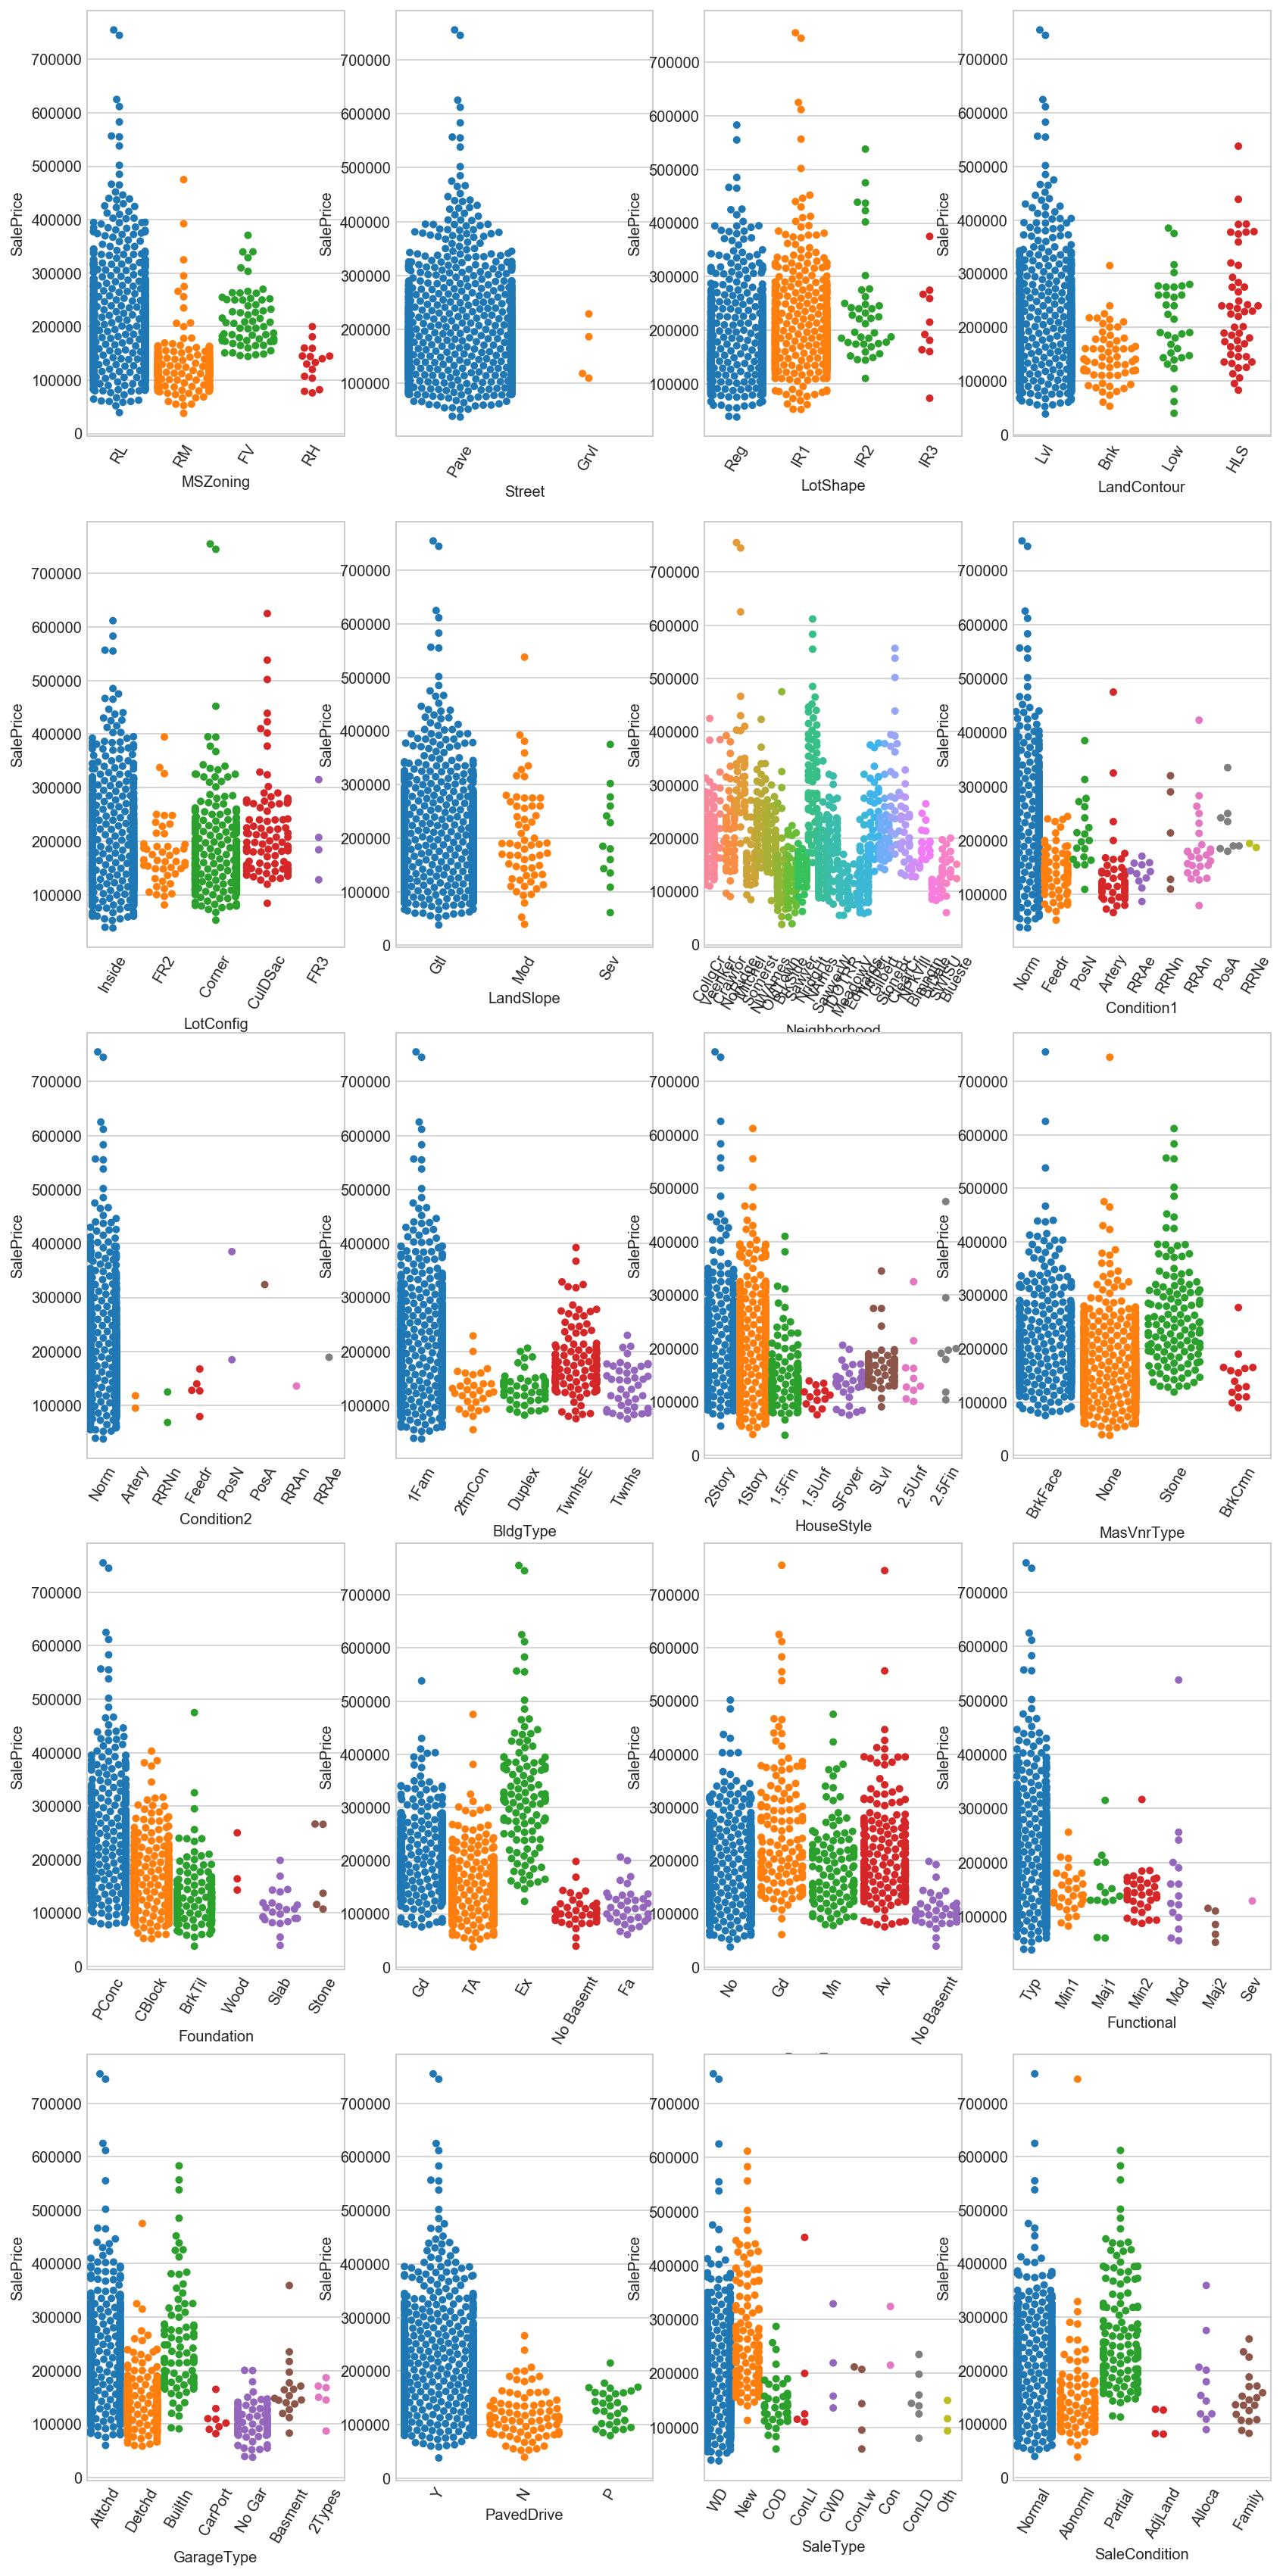

In [25]:
f,ax = plt.subplots(5,4, figsize= (14,30))
cycle = 0
i=0
for c in categorical.columns[0:-1]:
    sns.swarmplot(x = categorical[c], y= categorical.SalePrice, data = categorical,
                  ax=ax[cycle//4][i]).set_xticklabels(ax[cycle//4][i].xaxis.get_ticklabels(),rotation =60)
    if (i+1)%4 ==0:
        i=0
    else:
        i+=1        
    cycle+=1

<div class = 'alert alert-block alert-warning'>** Create first version of predictor dataframe**</div>

In [19]:
import patsy
res.rename(columns={'3SsnPorch':'SsnPorch', '1stFlrSF':'FirstFlrSF','2ndFlrSF':'SecFlrSF'},inplace=True)
res_drop = res.drop(['Id','PoolQC','MiscFeature'],axis = 1)
f = 'SalePrice ~ '+' + '.join([c for c in res_drop.columns if not c == 'SalePrice'])+' -1'
yall,Xall = patsy.dmatrices (formula_like = f, data = res_drop,return_type='dataframe')

In [20]:
import patsy
fixedfeature.rename(columns={'3SsnPorch':'SsnPorch', '1stFlrSF':'FirstFlrSF'},inplace=True)
f = 'SalePrice ~ '+' + '.join([c for c in fixedfeature.columns if not c == 'SalePrice'])+' -1'
yb,Xb = patsy.dmatrices (formula_like = f, data = fixedfeature,return_type='dataframe')

In [21]:
print res.shape
print Xall.shape
print fixedfeature.shape
print Xb.shape

(1450, 82)
(1450, 249)
(1450, 54)
(1450, 143)


In [22]:
Xa_train = Xall[~Xall.YrSold.isin([2010])]
Xa_test = Xall[Xall.YrSold.isin([2010])]
ya_train = yall[~Xall.YrSold.isin([2010])]
ya_test = yall[Xall.YrSold.isin([2010])]
print len(Xa_test) + len(Xa_train)
print len(Xa_test), len(ya_test)
print len(Xa_train), len(ya_train)

1450
172 172
1278 1278


In [23]:
Xb_train = Xb[~Xb.YrSold.isin([2010])]
Xb_test = Xb[Xb.YrSold.isin([2010])]
yb_train = yb[~Xb.YrSold.isin([2010])]
yb_test = yb[Xb.YrSold.isin([2010])]
print len(Xb_test) + len(Xb_train)
print len(Xb_test), len(yb_test)
print len(Xb_train), len(yb_train)

1450
172 172
1278 1278


<div class="alert alert-block alert-warning"> **Perform Scaling on features**</div>

In [24]:
from sklearn.preprocessing import StandardScaler
cat_a = [c for c in Xall.columns if c.count('[')>0]
num_a = [c for c in Xall.columns if c.count('[') == 0]
ss = StandardScaler()
Xsa_train = ss.fit_transform(Xa_train)
Xsa_test = ss.fit_transform(Xa_test)

In [25]:
from sklearn.preprocessing import StandardScaler
cat_b = [c for c in Xb.columns if c.count('[')>0]
num_b = [c for c in Xb.columns if c.count('[') == 0]
ss = StandardScaler()
Xsb_train = ss.fit_transform(Xb_train)
Xsb_test = ss.fit_transform(Xb_test)

In [26]:
print Xsa_train.shape
print Xsb_train.shape

(1278, 249)
(1278, 143)


In [27]:
print ya_test.equals(yb_test)
print ya_train.equals(yb_train)

True
True


<div class = 'alert alert-block alert-info'> $$Feature Selection - using SelectKBest$$ </div>

In [28]:
from sklearn.feature_selection import SelectKBest,f_classif,f_regression
skbcls = SelectKBest(f_classif, k=30)
skbcls.fit(Xb_train[cat_b],yb_train)
anova =pd.DataFrame (data =zip(cat_b, skbcls.scores_,skbcls.pvalues_,skbcls.get_support(indices=False)),columns = 
                     ['Col','Scores','p-value','ClsSupport']).sort_values('Scores',ascending=False)


/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


In [29]:
anova.iloc[0:50,:]

Col     Scores        p-value  ClsSupport
54          Condition2[T.RRAn]        inf   0.000000e+00        True
98             SaleType[T.Con]        inf   0.000000e+00        True
106    SaleCondition[T.Alloca]  16.951973  1.535996e-225        True
102            SaleType[T.New]   5.208333   1.566672e-89        True
109   SaleCondition[T.Partial]   4.790350   1.522315e-81        True
32     Neighborhood[T.NridgHt]   4.758429   6.432922e-81        True
31     Neighborhood[T.NoRidge]   3.467274   1.397359e-53        True
52          Condition2[T.PosN]   3.304458   7.529589e-50        True
4               Street[T.Pave]   3.301003   9.049130e-50        True
72          Foundation[T.Slab]   2.620134   1.411319e-33        True
40     Neighborhood[T.Veenker]   2.462781   9.621235e-30        True
6              LotShape[T.IR3]   2.412755   1.599928e-28        True
77       BsmtQual[T.No Basemt]   2.219365   8.232282e-24        True
69         MasVnrType[T.Stone]   2.193827   3.427353e-23        True
82   BsmtExposure[T.No Basemt]   2.162847   1.927249e-22        True
104             SaleType[T.WD]   2.149969   3.946375e-22        True
37     Neighborhood[T.Somerst]   2.120328   2.047566e-21        True
44          Condition1[T.PosN]   2.029486   3.079906e-19        True
0                 MSZoning[FV]   1.896882   4.103991e-16        True
76              BsmtQual[T.Gd]   1.802247   6.127254e-14        True
71         Foundation[T.PConc]   1.780936   1.856021e-13        True
92       GarageType[T.CarPort]   1.777787   2.184812e-13        True
91       GarageType[T.BuiltIn]   1.734126   2.057621e-12        True
78              BsmtQual[T.TA]   1.727762   2.844306e-12        True
38     Neighborhood[T.StoneBr]   1.712668   6.110230e-12        True
62        HouseStyle[T.2.5Fin]   1.704223   9.352900e-12        True
79          BsmtExposure[T.Gd]   1.592270   2.246957e-09        True
103            SaleType[T.Oth]   1.539086   2.685418e-08        True
108    SaleCondition[T.Normal]   1.515592   7.799137e-08        True
89        GarageType[T.Attchd]   1.495620   1.900699e-07        True
21     Neighborhood[T.CollgCr]   1.490108   2.424119e-07       False
7              LotShape[T.Reg]   1.466906   6.661248e-07       False
39      Neighborhood[T.Timber]   1.445195   1.681655e-06       False
22     Neighborhood[T.Crawfor]   1.435712   2.504237e-06       False
55          Condition2[T.RRNn]   1.415209   5.843018e-06       False
8           LandContour[T.HLS]   1.338525   1.159578e-04       False
11        LotConfig[T.CulDSac]   1.328665   1.664690e-04       False
64        HouseStyle[T.2Story]   1.309097   3.355635e-04       False
68          MasVnrType[T.None]   1.304914   3.886690e-04       False
99           SaleType[T.ConLD]   1.285446   7.592398e-04       False
46          Condition1[T.RRAn]   1.277158   1.002441e-03       False
81          BsmtExposure[T.No]   1.276564   1.022430e-03       False
16            LandSlope[T.Sev]   1.268854   1.318340e-03       False
60        HouseStyle[T.1.5Unf]   1.262909   1.599505e-03       False
70        Foundation[T.CBlock]   1.250580   2.370488e-03       False
93        GarageType[T.Detchd]   1.238998   3.397882e-03       False
36     Neighborhood[T.SawyerW]   1.209787   8.074974e-03       False
24     Neighborhood[T.Gilbert]   1.195547   1.203486e-02       False
18      Neighborhood[T.BrDale]   1.190020   1.399181e-02       False
94        GarageType[T.No Gar]   1.168909   2.433340e-02       False

In [30]:
skbreg = SelectKBest(f_regression, k=30)
skbreg.fit(Xb_train[num_b],yb_train)
f_reg =pd.DataFrame (data =zip(num_b, skbreg.scores_,skbreg.pvalues_,skbreg.get_support(indices=False)),columns = 
                     ['Col','Scores','p-value','RegSupport']).sort_values('Scores',ascending=False)


In [31]:
f_reg.iloc[0:50,:]

Col       Scores        p-value  RegSupport
4     OverallQual  2121.906559  1.177077e-273        True
14      GrLivArea  1283.995066  3.754887e-195        True
23     GarageArea   844.790678  5.962417e-143        True
12     FirstFlrSF   711.931203  5.296304e-125        True
17       FullBath   590.937056  1.412506e-107        True
21   TotRmsAbvGrd   495.104598   5.994537e-93        True
6       YearBuilt   453.592709   2.307673e-86        True
7    YearRemodAdd   438.748002   5.713139e-84        True
22     Fireplaces   358.346317   1.248677e-70        True
8      MasVnrArea   353.785611   7.462633e-70        True
9      BsmtFinSF1   198.815319   4.571252e-42        True
25    OpenPorchSF   160.695006   9.038155e-35        True
24     WoodDeckSF   158.499612   2.412262e-34        True
18       HalfBath   108.840323   1.648387e-24        True
2         LotArea    90.674853   8.160035e-21        True
15   BsmtFullBath    69.383442   2.068318e-16        True
1     LotFrontage    65.125064   1.609532e-15        True
11      BsmtUnfSF    64.888846   1.803995e-15        True
29          Fence    40.225370   3.134650e-10        True
19   BedroomAbvGr    36.921442   1.620998e-09        True
20   KitchenAbvGr    22.394252   2.467865e-06        True
26  EnclosedPorch    19.299778   1.209780e-05        True
3           Alley    18.319812   2.007221e-05        True
28    ScreenPorch    17.206206   3.575212e-05        True
32           Pool    12.793980   3.607454e-04        True
5     OverallCond     8.883877   2.931487e-03        True
0      MSSubClass     6.983160   8.328713e-03        True
30         MoSold     4.320797   3.784871e-02        True
27       SsnPorch     2.617107   1.059642e-01        True
31         YrSold     0.776598   3.783496e-01        True
13   LowQualFinSF     0.365700   5.454651e-01       False
16   BsmtHalfBath     0.261564   6.091363e-01       False
10     BsmtFinSF2     0.001811   9.660659e-01       False

<div class = 'alert alert-block alert-info'> $$Feature Selection - using RFE$$ </div>

In [39]:
from sklearn.linear_model import SGDRegressor
from sklearn.feature_selection import RFECV

In [79]:
bestalpha = []
l1ratio = []
scores = []
for ratio in np.arange(0,1,0.1):
    for alphas in np.arange(0,2,0.2):
        sgd_reg=SGDRegressor(loss = 'squared_loss', penalty = 'elasticnet', l1_ratio=ratio, alpha = alphas )
        reg_selector = RFECV(sgd_reg, step=1, cv=5)
        reg_selector = reg_selector.fit(Xsb_train, yb_train)
        scores.append(np.mean(reg_selector.grid_scores_))
        bestalpha.append(alphas)
        l1ratio.append(ratio)
rfescores = pd.DataFrame(data = zip(scores,bestalpha,l1ratio), columns= ['Scores','Bestalpha','l1ratio']).sort_values('Scores',ascending = False)
print rfescores.head(20)

      Scores  Bestalpha  l1ratio
64  0.803521        0.8      0.6
32  0.802701        0.4      0.3
75  0.802271        1.0      0.7
12  0.802010        0.4      0.1
53  0.801916        0.6      0.5
2   0.801819        0.4      0.0
52  0.801624        0.4      0.5
22  0.801589        0.4      0.2
63  0.801516        0.6      0.6
42  0.801434        0.4      0.4
88  0.801297        1.6      0.8
89  0.801086        1.8      0.8
1   0.801070        0.2      0.0
76  0.800752        1.2      0.7
74  0.800692        0.8      0.7
86  0.800674        1.2      0.8
87  0.800628        1.4      0.8
54  0.800613        0.8      0.5
85  0.800513        1.0      0.8
99  0.800398        1.8      0.9


In [40]:
sgd_reg=SGDRegressor(loss = 'squared_loss', penalty = 'elasticnet', l1_ratio= 0.6, alpha = 0.8)
reg_selector = RFECV(sgd_reg, step=1, cv=5)
reg_selector = reg_selector.fit(Xsb_train, yb_train)
reg_selector.grid_scores_

/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ 0.58352768,  0.68409968,  0.71063482,  0.72474931,  0.73010519,
        0.73117527,  0.7536243 ,  0.76017981,  0.76773506,  0.77546159,
        0.77545389,  0.76877268,  0.78679066,  0.78980784,  0.7918101 ,
        0.7969588 ,  0.79764655,  0.79419839,  0.79633436,  0.80572643,
        0.80440843,  0.80569584,  0.80538733,  0.80342825,  0.80268996,
        0.81398987,  0.81228947,  0.80817406,  0.80938561,  0.81384016,
        0.82389528,  0.82248493,  0.81074996,  0.81956852,  0.8153217 ,
        0.79677482,  0.81599935,  0.82298464,  0.81329212,  0.81618404,
        0.81327207,  0.82281314,  0.82541141,  0.82166206,  0.82350891,
        0.81224335,  0.81658552,  0.8189672 ,  0.8204618 ,  0.82625191,
        0.82425043,  0.8206412 ,  0.81997174,  0.81131283,  0.82022624,
        0.81997378,  0.81513082,  0.8141121 ,  0.80249549,  0.82359174,
        0.81102652,  0.80862578,  0.82378268,  0.82190887,  0.81879711,
        0.82408937,  0.8135949 ,  0.81628478,  0.8228939 ,  0.81

In [41]:
reg_rfe = pd.DataFrame(data = zip(Xb_train.columns,reg_selector.support_,reg_selector.ranking_),columns
             =['Col','True/False','Ranking']).sort_values('Ranking',ascending=True)

print np.mean(reg_selector.grid_scores_)
print reg_rfe['True/False'].sum()
reg_rfe[0:20]

0.801318306768
84


Col  True/False  Ranking
0                 MSZoning[FV]        True        1
98             SaleType[T.Con]        True        1
96             PavedDrive[T.Y]        True        1
95             PavedDrive[T.P]        True        1
93        GarageType[T.Detchd]        True        1
91       GarageType[T.BuiltIn]        True        1
88           Functional[T.Typ]        True        1
87           Functional[T.Sev]        True        1
83          Functional[T.Maj2]        True        1
82   BsmtExposure[T.No Basemt]        True        1
81          BsmtExposure[T.No]        True        1
102            SaleType[T.New]        True        1
79          BsmtExposure[T.Gd]        True        1
77       BsmtQual[T.No Basemt]        True        1
76              BsmtQual[T.Gd]        True        1
75              BsmtQual[T.Fa]        True        1
72          Foundation[T.Slab]        True        1
70        Foundation[T.CBlock]        True        1
69         MasVnrType[T.Stone]        True        1
68          MasVnrType[T.None]        True        1

<div class = 'alert alert-block alert-info'> Create new Xopt dataframe with selected best features, and use GridSearchCV to find the optimum hyperparameters</div>

In [42]:
bestfeatures_rfe = reg_rfe[reg_rfe['True/False'] == True]['Col'].tolist()
len(bestfeatures_rfe)

84

In [43]:
bestfeatures_skb= f_reg.Col.values[0:20].tolist()
bestfeatures_skb +=anova.Col.values[2:22].tolist()
len(bestfeatures_skb)

40

In [44]:
'YrSold' in bestfeatures_rfe

False

<div class = 'alert alert-block alert-warning'> **Create optimized version of predictor dataframe** </div>

In [45]:
Xopt = Xb[bestfeatures_rfe +['YrSold']]
Xopt.shape

(1450, 85)

In [46]:
Xopt_train = Xopt[~Xopt.YrSold.isin([2010])]
Xopt_test = Xopt[Xopt.YrSold.isin([2010])]
print Xopt_train.shape
print Xopt_test.shape
Xsb_train = ss.fit_transform(Xopt_train)
Xsb_test = ss.fit_transform(Xopt_test)

(1278, 85)
(172, 85)


In [48]:
from sklearn.model_selection import GridSearchCV
sgd_reg_params = {
    'loss':['squared_loss','huber','epsilon_insensitive', 'squared_epsilon_insensitive'],
    'penalty':['elasticnet','l2'],
    'alpha':(0.8, 5, 10, 20,50, 100,200, 500),
    'l1_ratio' : (0.5, 0.55,0.6, 0.65,0.7 )
}
sgd_reg2 = SGDRegressor()
sgdreg_gridopt = GridSearchCV(sgd_reg2,sgd_reg_params,verbose=True, cv=5)
sgdreg_gridopt.fit(Xsb_train, yb_train)


Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:   11.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=5, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['elasticnet', 'l2'], 'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'], 'l1_ratio': (0.5, 0.55, 0.6, 0.65, 0.7), 'alpha': (0.8, 5, 10, 20, 50, 100, 200, 500)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=True)

<div class = 'alert alert-block alert-info'>$$Model Performance$$</div>

In [49]:
print sgdreg_gridopt.best_score_
print sgdreg_gridopt.best_params_
y_pred = sgdreg_gridopt.predict(Xsb_test)
sgdreg_gridopt.score(Xsb_test, yb_test)

0.834308440911
{'penalty': 'elasticnet', 'alpha': 0.8, 'loss': 'squared_loss', 'l1_ratio': 0.65}


0.88422183381824326

R2 score =  0.884202995491


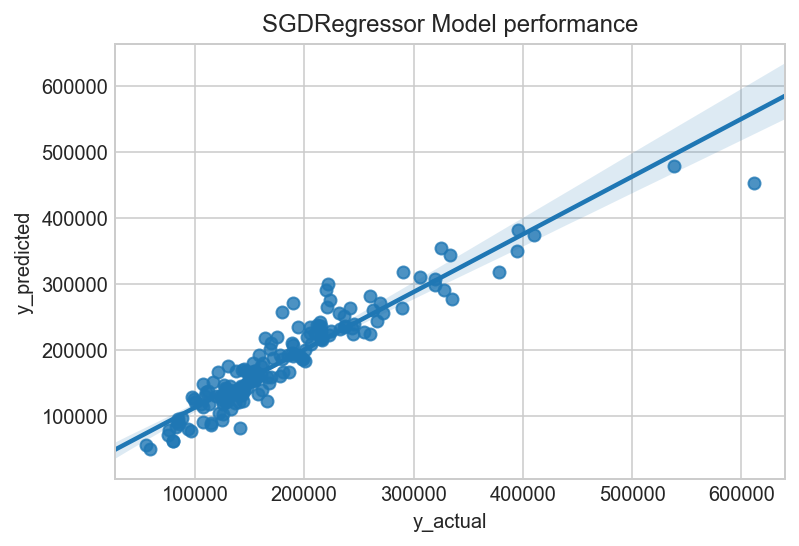

In [50]:
from sklearn.linear_model import SGDRegressor
sgd_reg3 = SGDRegressor(loss = 'squared_loss', penalty = 'elasticnet', l1_ratio= 0.6, alpha = 0.8)
sgd_reg3.fit(Xsb_train, yb_train)
y_pred_sg = sgd_reg3.predict(Xsb_test)
score_sg = sgd_reg3.score(Xsb_test, yb_test)

from sklearn.metrics import r2_score
sns.regplot(y=y_pred.ravel(), x = yb_test.SalePrice)
plt.title('SGDRegressor Model performance')
plt.ylabel('y_predicted')
plt.xlabel('y_actual')
print 'R2 score = ' , score_sg

<div class = 'alert alert-block alert-info'>With Linear Regression on every fixed feature</div>

R2 scores for all:  -2.0850981149e+22 (1278, 249)
R2 scores for best:  0.889176630784 (1278, 85)


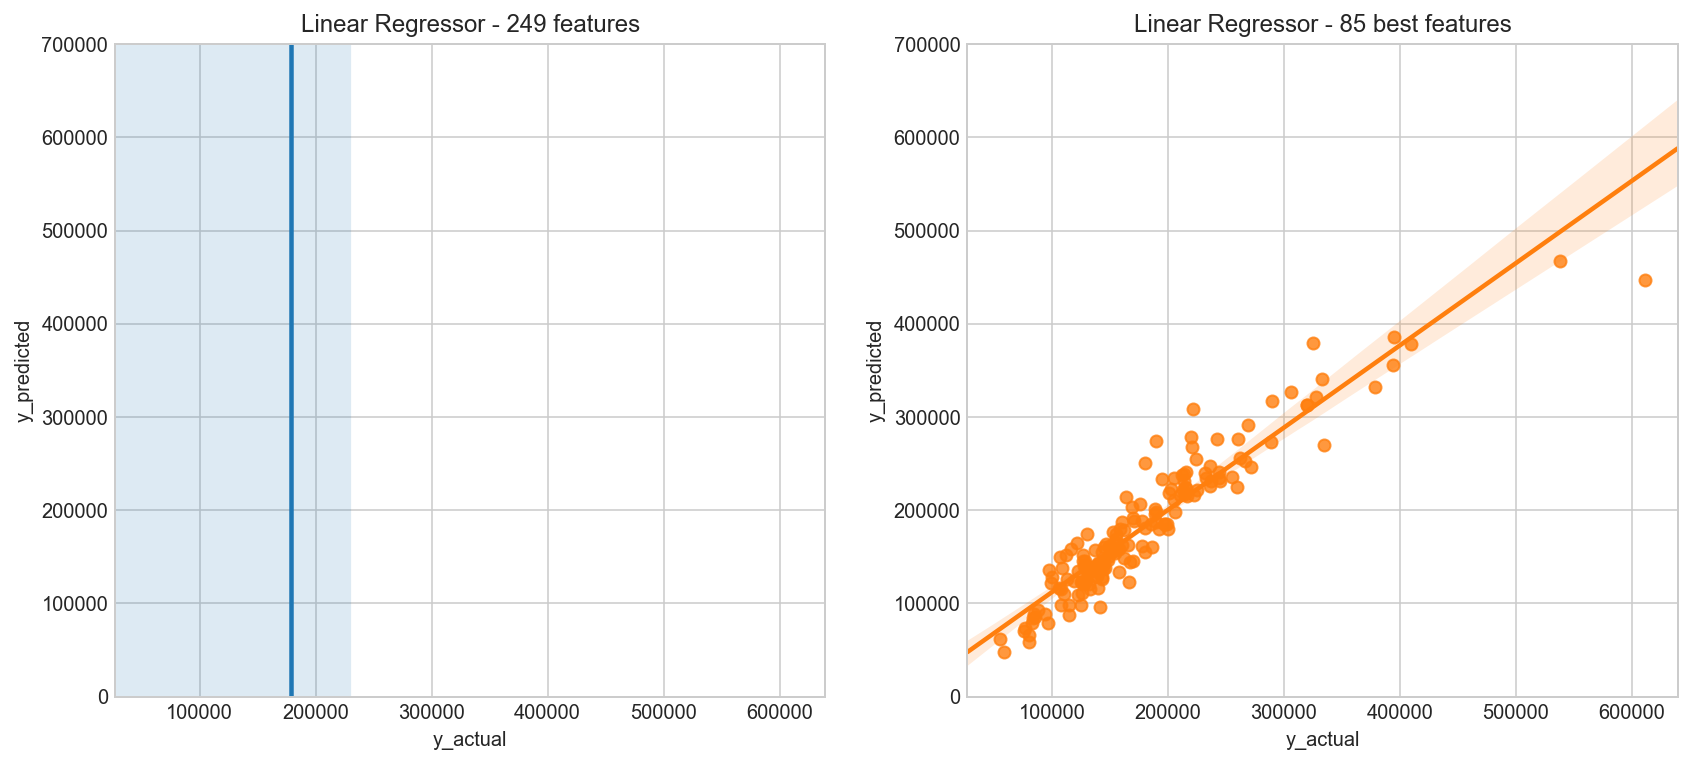

In [52]:
from sklearn.linear_model import LinearRegression
linreg1 = LinearRegression()
linreg2 = LinearRegression()

y_pred_all_lin =linreg1.fit(Xsa_train,ya_train).predict(Xsa_test)
score_all_lin =linreg1.score(Xsa_test,ya_test)

y_pred_best_lin = linreg2.fit(Xsb_train,yb_train).predict(Xsb_test)
score_best_lin = linreg2.score(Xsb_test,yb_test)

print 'R2 scores for all: ', score_all_lin , Xsa_train.shape
print 'R2 scores for best: ', score_best_lin, Xsb_train.shape

f,ax = plt.subplots(1,2,figsize = (14,6))

ax[0] = sns.regplot(y=y_pred_all_lin.ravel(), x = ya_test.SalePrice,ax= ax[0])
ax[0].set(ylim=(0,700000),title='Linear Regressor - 249 features',ylabel='y_predicted',xlabel='y_actual')

ax[1] =sns.regplot(y=y_pred_best_lin.ravel(), x = yb_test.SalePrice,ax=ax[1])
ax[1].set(ylim=(0,700000),title='Linear Regressor - 85 best features',ylabel='y_predicted',xlabel='y_actual')
plt.show()

<div class = 'alert alert-block alert-info'>With Ridge Regression on every fixed feature</div>

/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.44737577158e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)


R2 scores for all:  0.874030156817 (1278, 249) Best Alpha =  49
R2 scores for best:  0.891323804425 (1278, 85) Best Alpha =  49


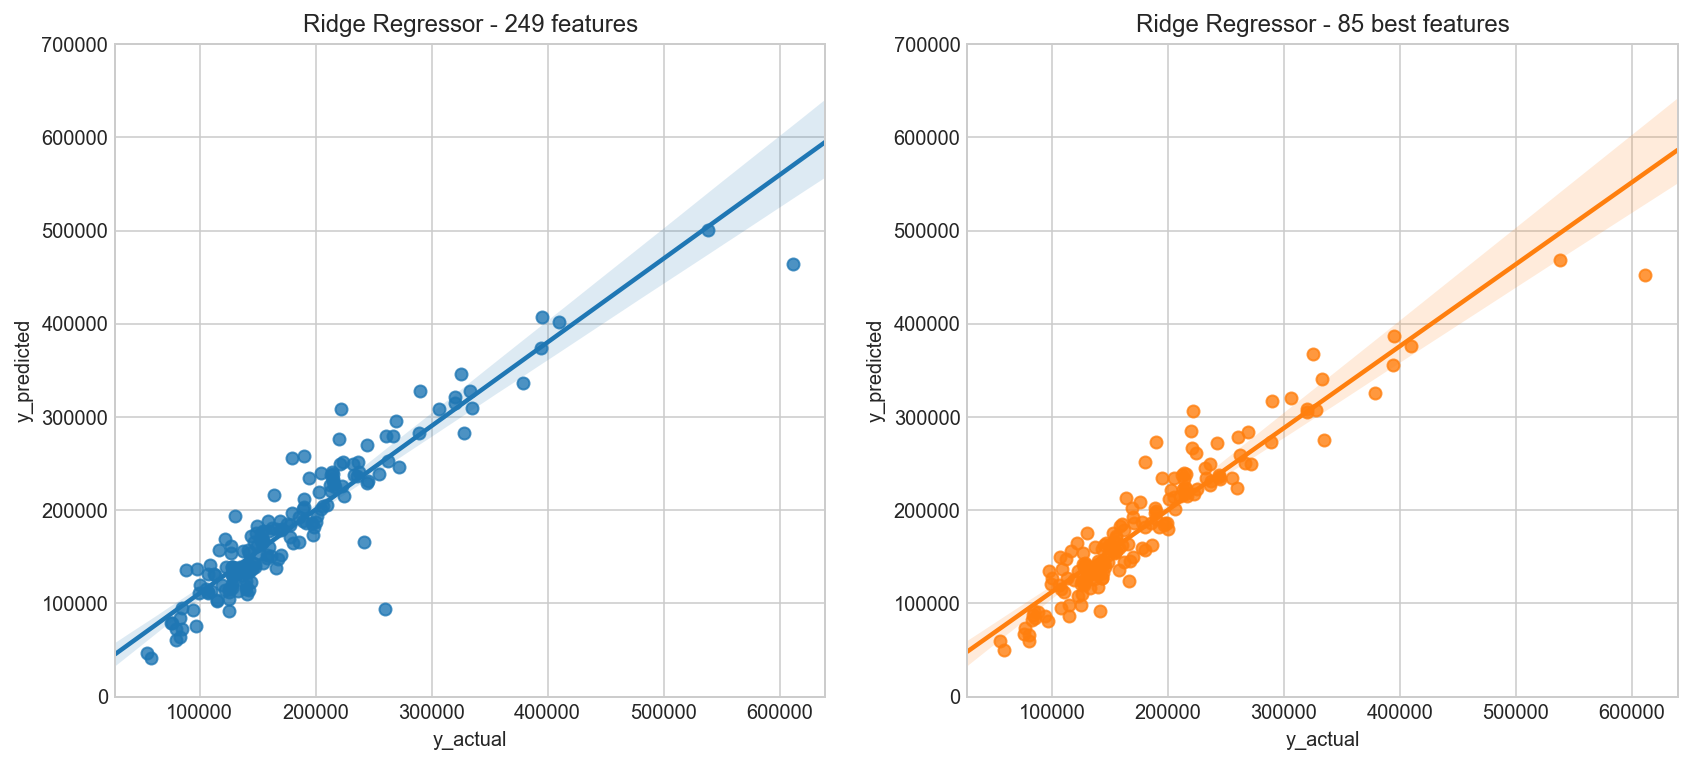

In [53]:
from sklearn.linear_model import RidgeCV
ridge1 = RidgeCV(alphas = np.arange(0,50, 1), cv =5)
ridge2 = RidgeCV(alphas = np.arange(0,50, 1), cv =5)

y_pred_all_r =ridge1.fit(Xsa_train,ya_train).predict(Xsa_test)
score_all_r =ridge1.score(Xsa_test,ya_test)

y_pred_best_r = ridge2.fit(Xsb_train,yb_train).predict(Xsb_test)
score_best_r = ridge2.score(Xsb_test,yb_test)

print 'R2 scores for all: ', score_all_r , Xsa_train.shape, 'Best Alpha = ', ridge1.alpha_
print 'R2 scores for best: ', score_best_r, Xsb_train.shape,'Best Alpha = ', ridge2.alpha_

f,ax = plt.subplots(1,2,figsize = (14,6))

ax[0] = sns.regplot(y=y_pred_all_r.ravel(), x = ya_test.SalePrice,ax= ax[0])
ax[0].set(ylim=(0,700000),title='Ridge Regressor - 249 features',ylabel='y_predicted',xlabel='y_actual')

ax[1] =sns.regplot(y=y_pred_best_r.ravel(), x = yb_test.SalePrice,ax=ax[1])
ax[1].set(ylim=(0,700000),title='Ridge Regressor - 85 best features',ylabel='y_predicted',xlabel='y_actual')
plt.show()

<div class = 'alert alert-block alert-info'>With Lasso Regression on every fixed feature</div>

/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:473: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


R2 scores for all:  0.876657962918 (1278, 249) Best Alpha =  490
R2 scores for best:  0.889109046885 (1278, 85) Best Alpha =  49


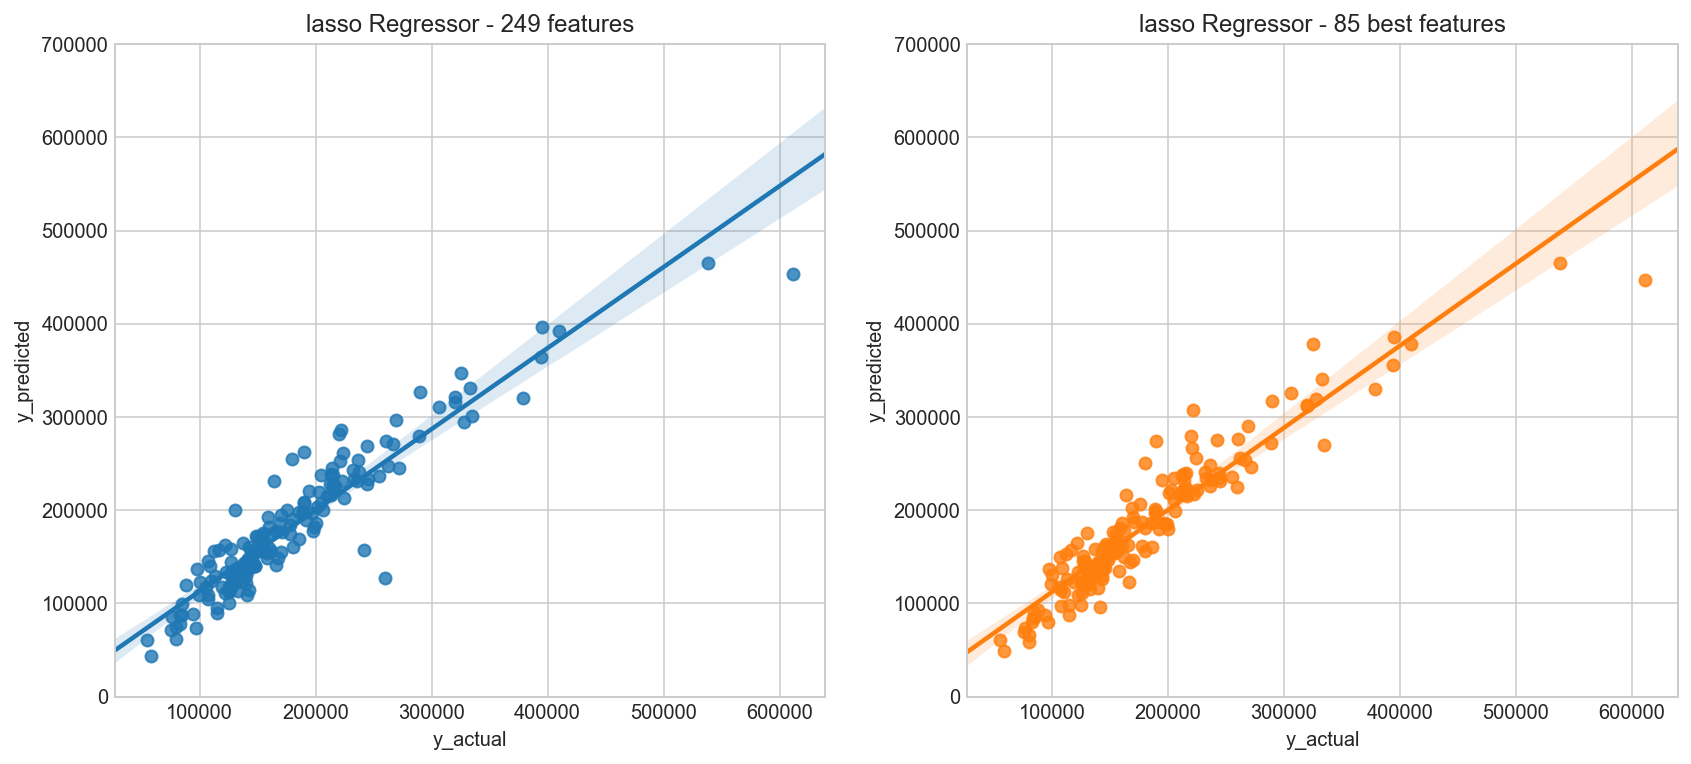

In [54]:
from sklearn.linear_model import LassoCV
lasso1 = LassoCV(alphas = np.arange(100,500, 10), cv =5)
lasso2 = LassoCV(alphas = np.arange(0,50, 1), cv =5)

y_pred_all_las =lasso1.fit(Xsa_train,ya_train).predict(Xsa_test)
score_all_las =lasso1.score(Xsa_test,ya_test)

y_pred_best_las = lasso2.fit(Xsb_train,yb_train).predict(Xsb_test)
score_best_las = lasso2.score(Xsb_test,yb_test)

print 'R2 scores for all: ', score_all_las , Xsa_train.shape, 'Best Alpha = ', lasso1.alpha_
print 'R2 scores for best: ', score_best_las, Xsb_train.shape,'Best Alpha = ', lasso2.alpha_

f,ax = plt.subplots(1,2,figsize = (14,6))

ax[0] = sns.regplot(y=y_pred_all_las.ravel(), x = ya_test.SalePrice,ax= ax[0])
ax[0].set(ylim=(0,700000),title='lasso Regressor - 249 features',ylabel='y_predicted',xlabel='y_actual')

ax[1] =sns.regplot(y=y_pred_best_las.ravel(), x = yb_test.SalePrice,ax=ax[1])
ax[1].set(ylim=(0,700000),title='lasso Regressor - 85 best features',ylabel='y_predicted',xlabel='y_actual')
plt.show()

In [75]:
compare = pd.DataFrame(data = zip(Xopt.columns, linreg2.coef_.ravel(),np.abs(linreg2.coef_.ravel()),
                        ridge2.coef_.ravel(),np.abs(ridge2.coef_.ravel()),
                        lasso2.coef_.ravel(),np.abs(lasso2.coef_.ravel()),
                        sgd_reg3.coef_.ravel(),np.abs(sgd_reg3.coef_.ravel())),
                       columns =['Cols','Lin','absLin','Ridge','absR','Las','absLas','SGD','absSGD']).sort_values('absLas',ascending=False)
compare.head(20)

Cols           Lin        absLin         Ridge  \
39                GrLivArea  21323.538971  21323.538971  16952.545371   
14           BsmtQual[T.Gd] -18821.419518  18821.419518 -13660.745498   
23           BsmtQual[T.TA] -18224.641035  18224.641035 -12103.203157   
47              OverallQual  15443.579071  15443.579071  15619.003639   
64  Neighborhood[T.NoRidge]   9601.169486   9601.169486   9362.966090   
70  Neighborhood[T.NridgHt]   8873.296463   8873.296463   8862.365029   
45                YearBuilt   6991.977235   6991.977235   6033.518562   
56  Neighborhood[T.StoneBr]   6284.527988   6284.527988   6160.038554   
51       Condition2[T.PosN]  -6316.393642   6316.393642  -5900.525307   
46              OverallCond   6239.695305   6239.695305   5613.523095   
26               MSSubClass  -5304.969179   5304.969179  -4314.002818   
15           BsmtQual[T.Fa]  -5322.732208   5322.732208  -3485.234117   
12       BsmtExposure[T.Gd]   4873.637855   4873.637855   4791.206069   
38             BsmtFullBath   4524.303902   4524.303902   4123.677380   
58  Neighborhood[T.Somerst]   4334.294534   4334.294534   3380.462445   
63       LandContour[T.Lvl]   4363.409810   4363.409810   3856.992619   
32               GarageArea   3972.753724   3972.753724   4551.669476   
11          SaleType[T.New]   6302.738697   6302.738697   3317.204706   
61  Neighborhood[T.Edwards]  -4033.286862   4033.286862  -3841.264884   
37                 FullBath   3829.887295   3829.887295   4548.175818   

            absR           Las        absLas           SGD        absSGD  
39  16952.545371  21479.474714  21479.474714  11224.219597  11224.219597  
14  13660.745498 -18268.024173  18268.024173  -6041.433364   6041.433364  
23  12103.203157 -17574.240746  17574.240746  -4600.448961   4600.448961  
47  15619.003639  15660.389961  15660.389961  13355.228367  13355.228367  
64   9362.966090   9622.499354   9622.499354   8656.189106   8656.189106  
70   8862.365029   8989.247867   8989.247867   8209.308745   8209.308745  
45   6033.518562   6925.108551   6925.108551   3602.966557   3602.966557  
56   6160.038554   6297.826686   6297.826686   5227.195936   5227.195936  
51   5900.525307  -6245.901104   6245.901104  -1203.724230   1203.724230  
46   5613.523095   6130.292864   6130.292864   4182.726065   4182.726065  
26   4314.002818  -5391.388798   5391.388798  -3000.470573   3000.470573  
15   3485.234117  -5096.352012   5096.352012  -1556.633693   1556.633693  
12   4791.206069   4853.478239   4853.478239   4232.794144   4232.794144  
38   4123.677380   4449.253802   4449.253802   3056.425146   3056.425146  
58   3380.462445   4299.485514   4299.485514   2400.198538   2400.198538  
63   3856.992619   4112.896222   4112.896222   2475.809553   2475.809553  
32   4551.669476   4016.818710   4016.818710   6280.830748   6280.830748  
11   3317.204706   3892.553187   3892.553187   3104.664559   3104.664559  
61   3841.264884  -3854.891409   3854.891409  -3323.418279   3323.418279  
37   4548.175818   3727.215661   3727.215661   5189.418794   5189.418794

<div class="alert alert-block alert-info"> Ridge model came up with the best R2 score of 0.8913 based on the best 85 features selected, but only edging ahead of the other models by a tiny bit. 
<br>
Also the most significant features are pretty consistent across all the models</div> 

In [76]:
print 'Mean SalePrice - Actual: \t \t \t',yb_test.values.mean()
print 'Mean SalePrice - Predicted with Best features: ',y_pred_best_r.mean()
print 'Difference of means = \t \t \t \t', yb_test.values.mean() - y_pred_best_r.mean()

Mean SalePrice - Actual: 	 	 	179167.0
Mean SalePrice - Predicted with Best features:  181989.782473
Difference of means = 	 	 	 	-2822.78247261


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

<div class="alert alert-block alert-info"> ** The way i interpret this question is: <br>
Change our target variable to be: SalePrice - Predicted SalePrice
<br>
And use the renovatable features to try to fit a model to explain this gap
<br>
Now let's create a dataframe with just the Renovatable features dropped and see how well our model can predict SalePrice**</div>

In [58]:
no_renov = res.drop(renovatable+['Id','PoolQC','MiscFeature'],axis = 1)
f = 'SalePrice ~ '+' + '.join([c for c in no_renov.columns if not c == 'SalePrice'])+' -1'
y_norenov,X_norenov = patsy.dmatrices (formula_like = f, data = no_renov,return_type='dataframe')

In [59]:
print res.shape
print no_renov.shape

(1450, 82)
(1450, 60)


In [60]:
Xnr_train = X_norenov[~X_norenov.YrSold.isin([2010])]
Xnr_test = X_norenov[X_norenov.YrSold.isin([2010])]
ynr_train = y_norenov[~X_norenov.YrSold.isin([2010])]
ynr_test = y_norenov[X_norenov.YrSold.isin([2010])]
cat_nr = [c for c in X_norenov.columns if c.count('[')>0]
num_nr = [c for c in X_norenov.columns if c.count('[') == 0]

ss = StandardScaler()
Xnr_train[num_nr] = ss.fit_transform(Xnr_train[num_nr])
Xnr_test[num_nr] = ss.fit_transform(Xnr_test[num_nr])
Xsnr_train = Xnr_train
Xsnr_test = Xnr_test

print Xnr_train.shape
print ynr_train.shape
print Xnr_test.shape
print ynr_test.shape

/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


(1278, 149)
(1278, 1)
(172, 149)
(172, 1)


In [61]:
from sklearn.linear_model import Lasso

y_pred_nr_te = ridge2.fit(Xsnr_train,ynr_train).predict(Xsnr_test).ravel()
y_pred_nr_tr = ridge2.predict(Xsnr_train).ravel()
score_nr = ridge2.score(Xsnr_test,ynr_test)
alpha_nr = ridge2.alpha_
y_pred_te = ridge2.fit(Xsb_train,yb_train).predict(Xsb_test).ravel()
y_pred_tr = ridge2.predict(Xsb_train).ravel()
score_b = ridge2.score(Xsb_test,yb_test)
alpha_b = ridge2.alpha_
print 'Max, mean residuals of Best features - No Reno: ',np.max(y_pred_te - y_pred_nr_te), np.mean(y_pred_te - y_pred_nr_te) , '\n'
print 'Max, mean residuals of Actual S.P - No Reno: ',np.max(ya_test.values.ravel() - y_pred_nr_te), np.mean(ya_test.values.ravel() - y_pred_nr_te) , '\n'

/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.62199077887e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)


Max, mean residuals of Best features - No Reno:  24999.5450048 91.8689046306 

Max, mean residuals of Actual S.P - No Reno:  167348.300417 -2730.91356798 



 R2 scores for No renov:  0.894455986505 (1278, 149) Best Alpha =  8
R2 scores for all:  0.874030156817 (1278, 249) Best Alpha =  49


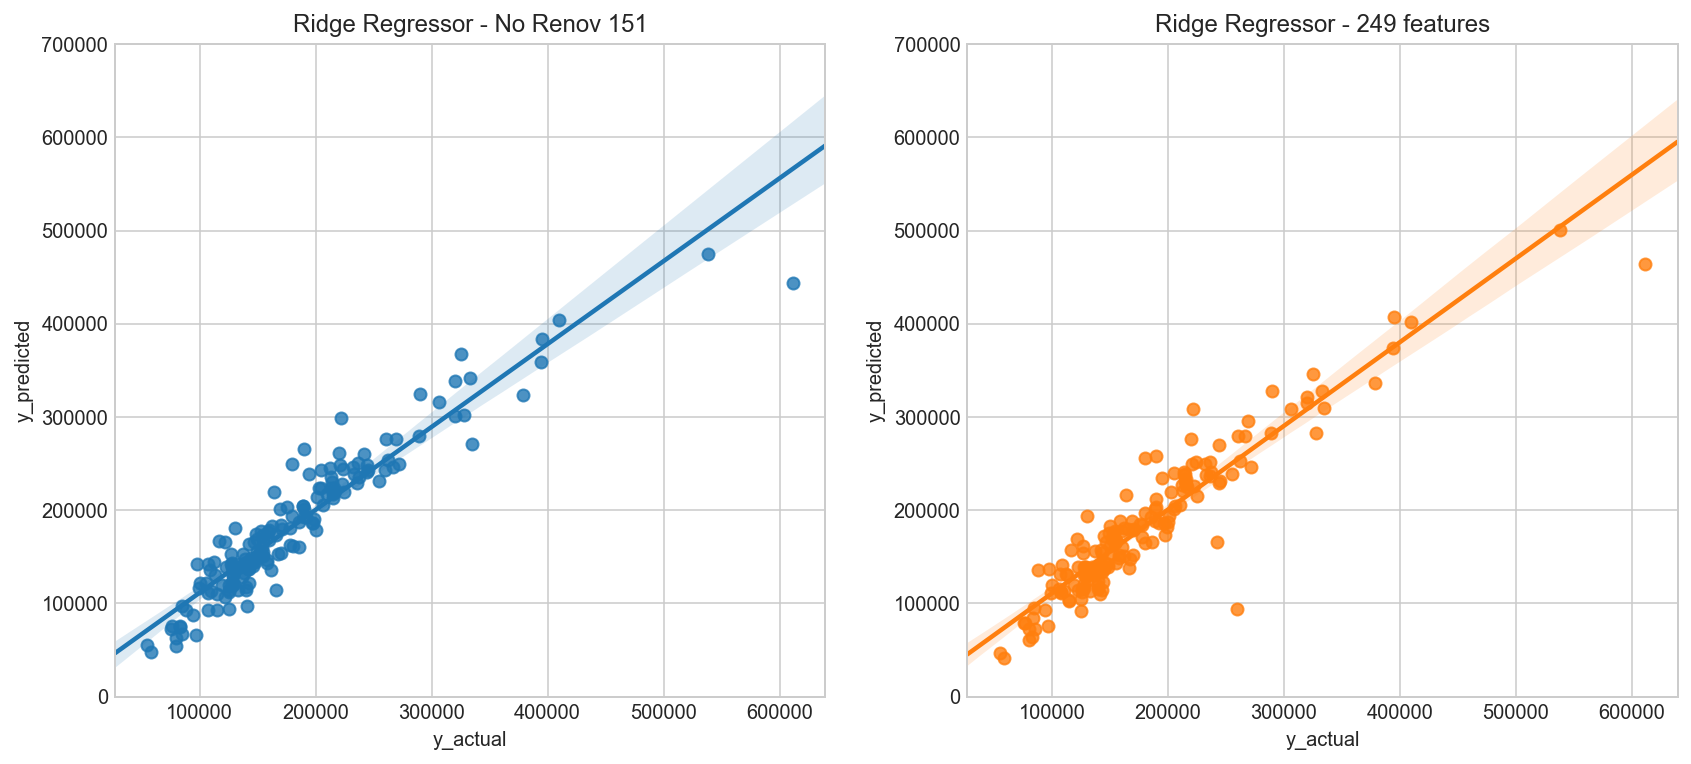

In [63]:
print 'R2 scores for No renov: ', score_nr , Xsnr_train.shape, 'Best Alpha = ', alpha_nr
print 'R2 scores for all: ', score_all_r , Xsa_train.shape, 'Best Alpha = ', ridge1.alpha_

f,ax = plt.subplots(1,2,figsize = (14,6))

ax[0] = sns.regplot(y=y_pred_nr_te.ravel(), x = ynr_test.SalePrice,ax= ax[0])
ax[0].set(ylim=(0,700000),title='Ridge Regressor - No Renov 151',ylabel='y_predicted',xlabel='y_actual')

ax[1] = sns.regplot(y=y_pred_all_r.ravel(), x = ya_test.SalePrice,ax= ax[1])
ax[1].set(ylim=(0,700000),title='Ridge Regressor - 249 features',ylabel='y_predicted',xlabel='y_actual')

plt.show()

<div class="alert alert-block alert-info"> **Basically, the renovatable features did not contribute much differences to our predictions! **
<br>
<br>
So let's assume now that the difference between ACTUAL SalePrice and our Predicted SalePrice based on NO renovatable features, is indeed due to the renovatable features.
<br>
If the renovatable features really can explain the residuals, we should be able to build a model with just the renovatable features and get a good R2 score for it.

</div>

In [77]:
# A:
Xnr_test['residual'] = (ya_test.values.ravel() - y_pred_nr_te)
Xnr_train['residual'] = (ya_train.values.ravel() - y_pred_nr_tr)

/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<div class = "alert alert-block alert-info"> **Perform GridSearchCV with Lasso to find a model which might explain the variance**</div>  

In [78]:
renov_effects = res[renovatable+['YrSold']]
f = ' ~ '+' + '.join([c for c in renov_effects.columns if not c == 'residual'])+' -1'
X_renov = patsy.dmatrix (formula_like = f, data = renov_effects,return_type='dataframe')

In [79]:
Xr_train = X_renov[~X_renov.YrSold.isin([2010])]
Xr_test = X_renov[X_renov.YrSold.isin([2010])]
yr_train = Xnr_train[['residual']]
yr_test = Xnr_test[['residual']]

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/model_selection/_validation.py:437: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    3.1s finished


 R2 scores for Renov:  0.105219937365 (1278, 102) Best Alpha:  Lasso(alpha=28, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


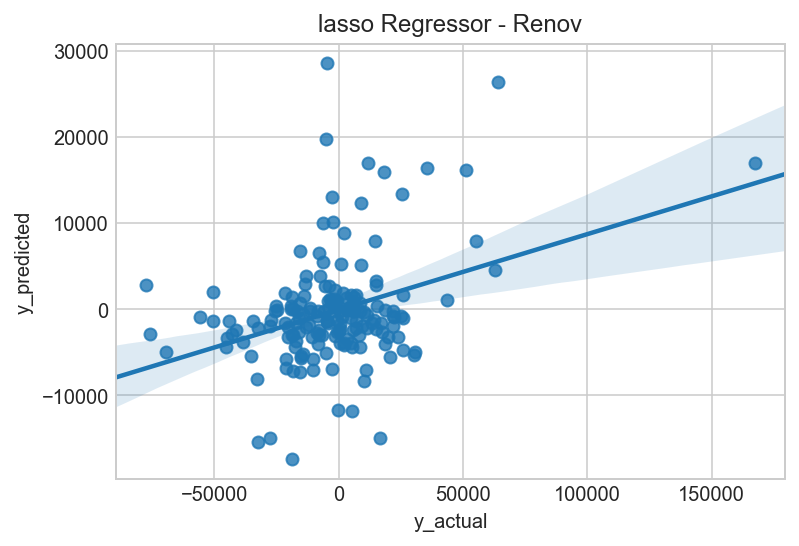

In [81]:
# from sklearn.linear_model import SGDRegressor,Ridge,Lasso
from sklearn.ensemble import AdaBoostRegressor
'''
linreg4 = LinearRegression()#alphas = np.arange(-2,5, 0.5), cv =5)
y_pred_renov = linreg4.fit(Xr_train,yr_train.values.ravel()).predict(Xr_test)
score_renov = linreg4.score(Xr_test,yr_test)


sgdreg2 = SGDRegressor()
sgdreg_params = {
     'loss':['squared_loss','huber'],
    'penalty':['l1','l2'],
    'alpha': np.arange(200,500,10)
}

ridge5 = Ridge(alpha = 50)
ridge_params = {
    'alpha': np.arange(0,30,1)
    
}
'''
lasso4 = Lasso(alpha=2)
lasso_params = {
    'alpha': np.arange(0,30,2)   
}

sgd_gridopt_reno = GridSearchCV(lasso4, lasso_params, verbose = True, cv=5)
sgd_gridopt_reno.fit(Xr_train,yr_train.values.ravel())
y_pred_renov = sgd_gridopt_reno.predict(Xr_test)
score_renov = sgd_gridopt_reno.score(Xr_test,yr_test)

print 'R2 scores for Renov: ', score_renov, Xr_train.shape, 'Best Alpha: ',  sgd_gridopt_reno.best_estimator_

sns.regplot(y=y_pred_renov, x = yr_test.residual).set(title='lasso Regressor - Renov',ylabel='y_predicted',xlabel='y_actual')
plt.show()

R2 scores for Renov:  0.116566971156 (1278, 102)

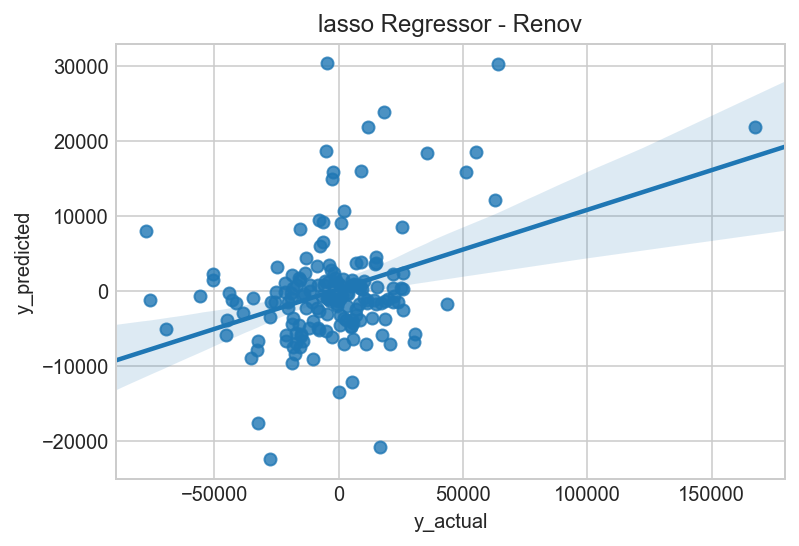

In [87]:
ada1 = AdaBoostRegressor(base_estimator=lasso4, n_estimators=50, learning_rate=0.001, loss='exponential', random_state=154)
ada1.fit(Xr_train,yr_train.values.ravel())
y_pred_renov = ada1.predict(Xr_test)
score_renov = ada1.score(Xr_test,yr_test)

print 'R2 scores for Renov: ', score_renov, Xr_train.shape, 

sns.regplot(y=y_pred_renov, x = yr_test.residual).set(title='lasso Regressor - Renov',ylabel='y_predicted',xlabel='y_actual')
plt.show()

In [88]:
lasso5 = Lasso(alpha = 28).fit(Xr_train,yr_train.values.ravel())
print pd.DataFrame(data = zip(Xr_train.columns,lasso5.coef_.ravel(),np.abs(lasso5.coef_.ravel())), 
                   columns = ['Col', 'Coefs','abs']).sort_values('abs',ascending=False)

                          Col          Coefs            abs
13        RoofMatl[T.WdShngl]  142505.990418  142505.990418
7         RoofMatl[T.CompShg]   80805.008989   80805.008989
8         RoofMatl[T.Membran]   65964.380939   65964.380939
12        RoofMatl[T.WdShake]   59361.426789   59361.426789
11        RoofMatl[T.Tar&Grv]   52328.265848   52328.265848
9           RoofMatl[T.Metal]   40724.086656   40724.086656
10           RoofMatl[T.Roll]   39475.927028   39475.927028
34     Exterior2nd[T.ImStucc]   22338.494606   22338.494606
69            Heating[T.OthW]  -21380.106849   21380.106849
81          KitchenQual[T.Gd]  -15030.175678   15030.175678
16     Exterior1st[T.BrkFace]   14121.291551   14121.291551
82          KitchenQual[T.TA]  -12499.156023   12499.156023
42     Exterior2nd[T.Wd Shng]  -11047.126075   11047.126075
4            RoofStyle[T.Hip]   -9550.196486    9550.196486
2          RoofStyle[T.Gable]   -9369.326435    9369.326435
80          KitchenQual[T.Fa]   -8216.81

<div class="alert alert-block alert-info"> Now let's convert residual column into a binary class target variable, to determine if it is a good profit-making opportunity. So we define any instance where Actual SalePrice - Predicted SalePrice >30000 as a good opportunity. And we use Logistic Regression to see if the renovatable features can help to predict these opportunities.</div>

In [89]:
yr_cls_train = yr_train.residual.map(lambda x: 1 if x > 30000 else 0)
yr_cls_test = yr_test.residual.map(lambda x: 1 if x > 30000 else 0)

In [90]:
print yr_cls_train.shape
print yr_cls_test.shape
print yr_cls_train.value_counts()
print yr_cls_test.value_counts()

(1278,)
(172,)
0    1201
1      77
Name: residual, dtype: int64
0    163
1      9
Name: residual, dtype: int64


In [93]:
from imblearn.over_sampling import RandomOverSampler,SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalanceCascade

unsam = RandomOverSampler(ratio=0.8,random_state = 9)
Xr_tr_sam,yr_tr_sam = unsam.fit_sample(Xr_train,yr_cls_train)
print Xr_tr_sam.shape
print yr_tr_sam.shape
print np.sum(yr_tr_sam==1)
print Xr_train.shape
print yr_train.shape
print np.sum(yr_cls_train.values==1)

(2161, 102)
(2161,)
960
(1278, 102)
(1278, 1)
77


/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,auc,confusion_matrix,classification_report,accuracy_score
from sklearn.svm import SVC
def logreg_roc(C,class_ratio):
    logreg2 = LogisticRegression(C =C, class_weight={1:class_ratio,0:1-class_ratio},penalty='l1', solver='liblinear')
    logreg2.fit(Xr_train,yr_cls_train)
    y_pred_r = logreg2.predict(Xr_test)
    scored_r = logreg2.score(Xr_test,yr_cls_test)

    '''def svc_roc(C):
    svc = SVC(kernel='rbf',C=C,probability =True)
    svc.fit(Xr_train,yr_cls_train)
    y_pred_r = svc.predict(Xr_test)
    scored_r = svc.score(Xr_test,yr_cls_test)'''
    
    print 'Accuracy : ', scored_r 
    print 'Confusion Matrix : \n', confusion_matrix(yr_cls_test,y_pred_r)
    print 'Classification Report: \n', classification_report(yr_cls_test,y_pred_r)

    fpr,tpr, _ = roc_curve(yr_cls_test,logreg2.predict_proba(Xr_test)[:,1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=[6,6])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver operating characteristic: Good Opp', fontsize=14)
    plt.legend(loc="lower right")
    plt.show()

In [97]:
from ipywidgets import *
from IPython.display import display

interact(logreg_roc, 
         C=FloatSlider(min=0, max=5.0, value=10.0, step=0.2),
         class_ratio=FloatSlider(min=0.3, max=0.95, value=0.7, step=0.05))

<function __main__.logreg_roc>

In [98]:
logreg2 = LogisticRegression(C =0.8, class_weight={1:0.75,0:0.25},penalty='l1', solver='liblinear')
logreg2.fit(Xr_train,yr_cls_train)
y_pred_r = logreg2.predict(Xr_test)
scored_r = logreg2.score(Xr_test,yr_cls_test)

<img src ='https://i.pinimg.com/736x/ee/93/6b/ee936b8652ee5baf0906d25ab8591411--wood-shingles-roofing-shingles.jpg'>
<img src='https://i.pinimg.com/originals/e6/f4/f8/e6f4f8923d2012f05673da66c6e85d97.jpg'>

In [99]:
print pd.DataFrame(data = zip(Xr_train.columns,logreg2.coef_.ravel()), 
                   columns =['Cols', 'Coefs']).sort_values('Coefs',ascending =False)

                          Cols     Coefs
13         RoofMatl[T.WdShngl]  1.127824
16      Exterior1st[T.BrkFace]  1.079854
32      Exterior2nd[T.CmentBd]  0.672484
4             RoofStyle[T.Hip]  0.554270
55         BsmtFinType1[T.GLQ]  0.545211
58         BsmtFinType1[T.Rec]  0.402238
65         BsmtFinType2[T.Unf]  0.295662
101                     YrSold  0.000060
63   BsmtFinType2[T.No Basemt]  0.000000
69             Heating[T.OthW]  0.000000
68             Heating[T.Grav]  0.000000
67             Heating[T.GasW]  0.000000
66             Heating[T.GasA]  0.000000
64         BsmtFinType2[T.Rec]  0.000000
61         BsmtFinType2[T.GLQ]  0.000000
62         BsmtFinType2[T.LwQ]  0.000000
71             HeatingQC[T.Fa]  0.000000
60         BsmtFinType2[T.BLQ]  0.000000
57   BsmtFinType1[T.No Basemt]  0.000000
56         BsmtFinType1[T.LwQ]  0.000000
54         BsmtFinType1[T.BLQ]  0.000000
53              BsmtCond[T.TA]  0.000000
52              BsmtCond[T.Po]  0.000000
1            Uti

<div class="alert alert-block alert-danger"> ** In summary, the renovatable features don't seem to be able to explain the variance between the Actual and Predicted SalePrices. Hence I wouldn't encourage the company to use this model and its coefficients to determine whether to buy a property or not. I don't trust this model for Qn2, use at your own risk!!** </div>

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [100]:
# A:
res['Abnormal'] = res.SaleCondition.map(lambda x: 1 if x == 'Abnorml' else 0)
res.MiscFeature = res.MiscFeature.map(lambda x : 'None' if str(x) == 'nan' else x)

/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [101]:
print res['Abnormal'].value_counts()
print res.MiscFeature.unique()

0    1354
1      96
Name: Abnormal, dtype: int64
['None' 'Shed' 'Gar2' 'Othr' 'TenC']


In [102]:
ab_sale = res.drop(['Id','PoolQC','SaleCondition'],axis = 1)

f = 'Abnormal ~ '+' + '.join([c for c in ab_sale.columns if not c == 'Abnormal'])+' -1'
y_abn,X_abn = patsy.dmatrices (formula_like = f, data = ab_sale,return_type='dataframe')

In [103]:
cat_ab = [c for c in X_abn.columns if c.count('[')>0]
num_ab = [c for c in X_abn.columns if c.count('[') == 0]

ss = StandardScaler()
X_abn[num_ab] = ss.fit_transform(X_abn[num_ab])

In [104]:
from sklearn.feature_selection import chi2
skbcls2 = SelectKBest(chi2, k=20)
skbcls2.fit(X_abn[cat_ab],y_abn)
abn_chi2 =pd.DataFrame (data =zip(X_abn.columns, skbcls2.scores_,skbcls2.pvalues_,skbcls2.get_support(indices=False)),columns = 
                     ['Col','Scores','p-value','ClsSupport']).sort_values('Scores',ascending=False)

In [105]:
abn_chi2.head(20)

Col     Scores       p-value  ClsSupport
207           SaleType[T.Oth]  42.312500  7.779375e-11        True
89       Exterior1st[T.Stone]  28.208333  1.089345e-07        True
1                MSZoning[RH]  15.698949  7.426541e-05        True
11        Utilities[T.NoSeWa]  14.104167  1.729602e-04        True
169         Functional[T.Sev]  14.104167  1.729602e-04        True
160         Electrical[T.Mix]  14.104167  1.729602e-04        True
181      GarageType[T.No Gar]   9.383225  2.189800e-03        True
192      GarageCond[T.No Gar]   9.383225  2.189800e-03        True
187      GarageQual[T.No Gar]   9.383225  2.189800e-03        True
182    GarageFinish[T.No Gar]   9.383225  2.189800e-03        True
206           SaleType[T.New]   8.649926  3.270746e-03        True
172         FireplaceQu[T.Gd]   8.475741  3.599138e-03        True
177     GarageType[T.Basment]   7.086848  7.765169e-03        True
127            BsmtQual[T.TA]   7.054322  7.907422e-03        True
81     Exterior1st[T.BrkComm]   6.087534  1.361390e-02        True
130            BsmtCond[T.Po]   6.087534  1.361390e-02        True
173  FireplaceQu[T.No Firepl]   6.014628  1.418777e-02        True
156           HeatingQC[T.TA]   5.650194  1.745344e-02        True
120       Foundation[T.PConc]   5.502593  1.898830e-02        True
33    Neighborhood[T.NridgHt]   5.459380  1.946356e-02        True

In [106]:
best_abn = abn_chi2[abn_chi2['p-value']<0.01]['Col'].tolist()
len(best_abn)

14

In [132]:
from sklearn.cross_validation import train_test_split
Xab_train, Xab_test, yab_train, yab_test = train_test_split(X_abn[best_abn+num_ab], y_abn, test_size=0.3,stratify=y_abn)

In [133]:
unsam = RandomOverSampler(ratio=0.8,random_state = 10)
X_tr_sam,y_tr_sam = unsam.fit_sample(Xab_train,yab_train)
print X_tr_sam.shape
print y_tr_sam.shape
print np.sum(y_tr_sam==1)
print Xab_train.shape
print yab_train.shape
print np.sum(yab_train.values==1)

(1706, 54)
(1706,)
758
(1015, 54)
(1015, 1)
67


/Users/bernt73/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Accuracy :  0.731034482759
Confusion Matrix : 
[[303 103]
 [ 14  15]]
Classification Report: 
             precision    recall  f1-score   support

        0.0       0.96      0.75      0.84       406
        1.0       0.13      0.52      0.20        29

avg / total       0.90      0.73      0.80       435



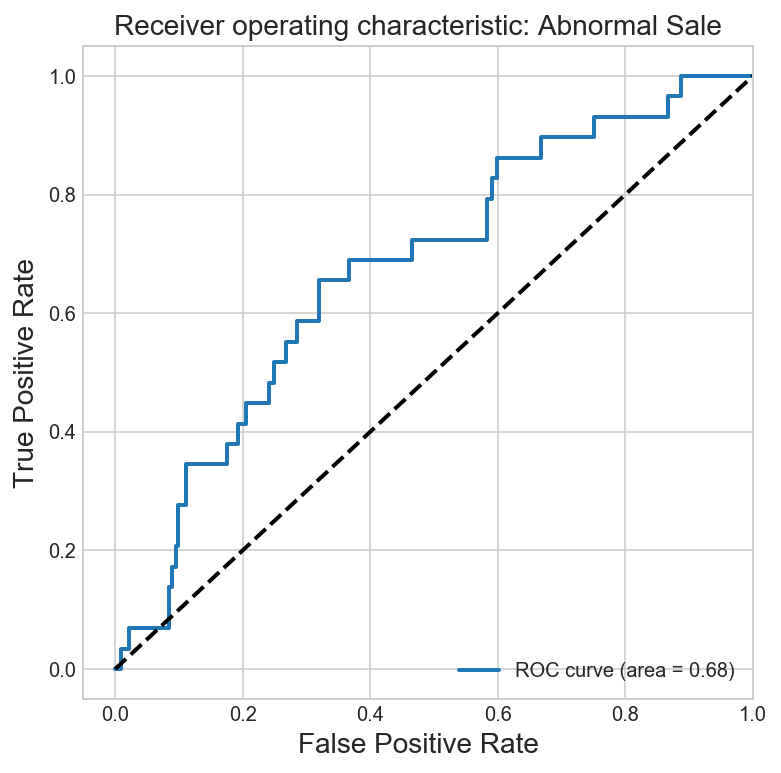

In [160]:
from sklearn.linear_model import LogisticRegression
logreg3 = LogisticRegression(C =80, class_weight={1:1.0,0:0.7},penalty='l1', solver='liblinear')
logreg3.fit(X_tr_sam,y_tr_sam.ravel())
y_pred_ab = logreg3.predict(Xab_test)
scored_ab = logreg3.score(Xab_test,yab_test)

print 'Accuracy : ', scored_ab 
print 'Confusion Matrix : \n', confusion_matrix(yab_test,y_pred_ab)
log_report = classification_report(yab_test,y_pred_ab)
print 'Classification Report: \n', log_report

fpr_ab,tpr_ab, _ = roc_curve(yab_test,logreg3.predict_proba(Xab_test)[:,1])
roc_auc_ab = auc(fpr_ab, tpr_ab)

plt.figure(figsize=[6,6])
plt.plot(fpr_ab, tpr_ab, label='ROC curve (area = %0.2f)' % roc_auc_ab, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic: Abnormal Sale', fontsize=14)
plt.legend(loc="lower right")
plt.show()

<script src="https://unpkg.com/jupyter-js-widgets@~2.1.4/dist/embed.js"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 1,
    "version_minor": 0,
    "state": {}
}
</script>

Accuracy :  0.742528735632
Confusion Matrix : 
[[311  95]
 [ 17  12]]
Classification Report: 
             precision    recall  f1-score   support

        0.0       0.95      0.77      0.85       406
        1.0       0.11      0.41      0.18        29

avg / total       0.89      0.74      0.80       435



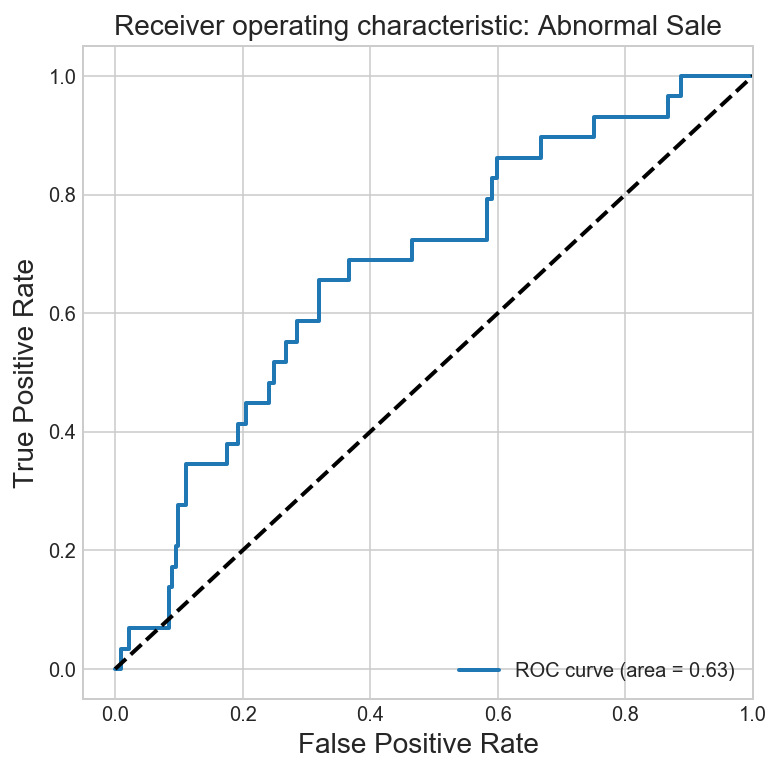

In [184]:
from sklearn.svm import SVC

svccls = SVC(kernel='rbf',degree=2, gamma =0.000012,C=50,probability =True)
#svccls = SVC(kernel='linear',C=50,probability =True)
svcmodel = svccls.fit(X_tr_sam,y_tr_sam)
y_pred_abn_svc = svccls.predict(Xab_test)
score_pred_abn_svc = svccls.score(Xab_test,yab_test)

fpr_svc,tpr_svc, _ = roc_curve(yab_test,svccls.predict_proba(Xab_test)[:,1])
roc_auc_svc = auc(fpr_svc,tpr_svc)

print 'Accuracy : ', score_pred_abn_svc 
print 'Confusion Matrix : \n', confusion_matrix(yab_test,y_pred_abn_svc)
svc_report = classification_report(yab_test,y_pred_abn_svc)
print 'Classification Report: \n', svc_report
plt.figure(figsize=[6,6])
plt.plot(fpr_ab, tpr_ab, label='ROC curve (area = %0.2f)' % roc_auc_svc, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver operating characteristic: Abnormal Sale', fontsize=14)
plt.legend(loc="lower right")
plt.show()

In [196]:
from sklearn.ensemble import AdaBoostClassifier
ada2 = AdaBoostClassifier(base_estimator=logreg3, n_estimators=20, learning_rate=20,algorithm='SAMME.R')
ada2.fit(X_tr_sam,y_tr_sam)
y_pred_abn_ada =ada2.predict(Xab_test)
score_pred_abn_ada = ada2.score(Xab_test,yab_test)
confusion_matrix(yab_test,y_pred_abn_ada)

array([[284, 122],
       [ 18,  11]])

In [186]:
print 'Log :'
print log_report, '\n'
print 'SVC : '
print svc_report, '\n'

Log :
             precision    recall  f1-score   support

        0.0       0.96      0.75      0.84       406
        1.0       0.13      0.52      0.20        29

avg / total       0.90      0.73      0.80       435


SVC : 
             precision    recall  f1-score   support

        0.0       0.95      0.77      0.85       406
        1.0       0.11      0.41      0.18        29

avg / total       0.89      0.74      0.80       435




<div class = "alert alert-block alert-warning"> SaleCondition - Condition of sale:
<br><br>
       Normal	Normal Sale<br><br>
       Abnormal	Abnormal Sale -  trade, foreclosure, short sale
<br>       
**Both Logistic Regression and SVClassifier cannot get good F1 score for predicting whether the Sale Condition is abnormal or not. Even with AdaBoost Classifier, it's also not improving the result. Hence, the features in the dataset don't seem to be able to predict if a Sale Condition is Abnormal. This makes sense as the features in the dataset are related only to the house. While, Abnormal sale conditions are more likely to be related to financial or personal reasons.**

<br>       
Major Reasons For Foreclosure :<br>
Illness <br> 
Divorce <br> 
Job Loss Reason of Foreclosure <br> 
Unexpected Maintenance Expenses <br> 
Death Reason of Foreclosure <br> 
Negative Equity Reason of Foreclosure <br> 
Five D’s of Foreclosure <br> 
Death <br> 
Divorce <br> 
Drugs <br> 
Disease <br> 
Denial <br> 
Adjustable Rate Loans <br>
Financial Irresponsibility <br> 
Relocation Reason of Foreclosure <br></div>

<img src = "https://previews.123rf.com/images/feverpitched/feverpitched1004/feverpitched100400007/6719094-Short-Sale-Home-For-Sale-Real-Estate-Sign-in-Front-of-New-House-Left-Facing--Stock-Photo.jpg">
<img src = "https://fthmb.tqn.com/bAMBErv80TtwEzpPnCc-oSzib2o=/400x0/filters:no_upscale()/84186033-56a493d65f9b58b7d0d7a4e9.jpg">